# now we can load them in, let's calculate things!

In [3]:
#the important difference with dsQTL is sometimes variant is too far away, so can't use it

#let's first load it in!

from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt


def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    '''
    Predicts variant effect scores based on model predictions.

    Arguments::
       ref_logcount_preds: log count predictions at the reference allele with size (N,)
       alt_logcount_preds: log count predictions at the alternate alele with size (N,)
       ref_prob_preds: profile probability predictions at the reference allele with size (N,outputlen). outputlen depends on the model.
       alt_prob_preds:  profile probability predictions at the alternate allele with size (N,outputlen). outputlen depends on the model.
    
    Returns:
        log_counts_diff: difference in log count predictions of alternate and reference allele (N,)
        log_probs_diff_abs_sum: Sum of absolute difference in log probability prediction of alternate and reference allele per base. (N,)
        probs_jsd_diff: Jensenshannon distance between probability predictions of alternate and reference allele (N,)
    '''
    # log_counts_diff = np.mean(alt_prob_preds, axis=1) - np.mean(ref_prob_preds, axis=1) #model doesn't have count prediction head, so it's really bad!
    # log_counts_diff = alt_count_preds - ref_count_preds
    
    log_probs_diff_abs_sum =  np.sum(np.abs(np.log(alt_prob_preds) -  np.log(ref_prob_preds)),axis=1)
    probs_jsd_diff = np.array([jensenshannon(x,y) for x,y in zip(alt_prob_preds, ref_prob_preds)])
    # integrative_effect_size = log_probs_diff_abs_sum * probs_jsd_diff
    logfc = np.log2(ref_prob_preds.mean(1) / alt_prob_preds.mean(1))
    integrative_effect_size = logfc * probs_jsd_diff
    integrative_effect_size_2 = log_probs_diff_abs_sum * probs_jsd_diff

    return logfc, log_probs_diff_abs_sum, probs_jsd_diff, integrative_effect_size, integrative_effect_size_2

#obviously if the values are zero, that makes log an issue, so if the sum is 0 need to ignore it

In [4]:
import numpy as np
def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    """
    ref_prob_preds, alt_prob_preds: arrays of shape (N, L)
    returns five length-N arrays, with zeros for any row where both inputs are all-zero.
    """
    # 1) mask out rows where both ref & alt are entirely zero
    zero_mask = (ref_prob_preds.sum(axis=1) == 0) & (alt_prob_preds.sum(axis=1) == 0)
    valid    = ~zero_mask
    N        = ref_prob_preds.shape[0]
    
    # 2) prepare empty outputs
    logfc                    = np.zeros(N, dtype=float)
    log_probs_diff_abs_sum   = np.zeros(N, dtype=float)
    probs_jsd_diff           = np.zeros(N, dtype=float)
    integrative_effect_size  = np.zeros(N, dtype=float)
    integrative_effect_size2 = np.zeros(N, dtype=float)
    
    # 3) only compute on the valid rows
    if np.any(valid):
        r = ref_prob_preds[valid]
        a = alt_prob_preds[valid]
        
        # sum of absolute log-diffs
        lpd = np.sum(np.abs(np.log(a) - np.log(r)), axis=1)
        # Jensen-Shannon distance, one-by-one
        jsd = np.array([jensenshannon(x, y) for x,y in zip(a, r)])
        # log₂ fold-change of mean probabilities
        lf  = np.log2(r.mean(axis=1) / a.mean(axis=1))
        # two “integrative” sizes
        ies  = lf * jsd
        ies2 = lpd * jsd
        
        # 4) scatter them back into the full-size arrays
        log_probs_diff_abs_sum[valid]   = lpd
        probs_jsd_diff[valid]           = jsd
        logfc[valid]                    = lf
        integrative_effect_size[valid]  = ies
        integrative_effect_size2[valid] = ies2
    
    # 5) return—all-zero rows remain at zero
    return logfc, \
           log_probs_diff_abs_sum, \
           probs_jsd_diff, \
           integrative_effect_size, \
           integrative_effect_size2

eqtl_enformer = np.load('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/enformer_eqtl.npy')
eqtl_enformer.shape

(1331, 896, 2)

In [5]:
#now put it in
out = predict_snp_effect_scores(eqtl_enformer[:,:,0], eqtl_enformer[:,:,1])

In [ ]:
#let's see how many nan are in out
for i in out:
    print(np.isnan(i).sum()) #perfect, none!

0
0
0
0
0


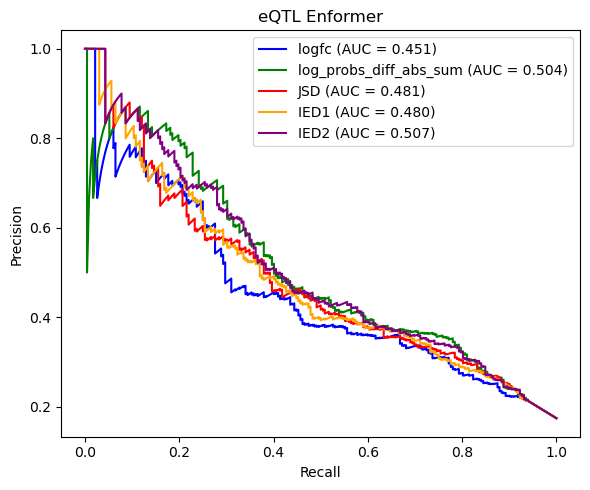

In [7]:
def plot_metrics(out, labels, title):
    model_names = ['logfc', 'log_probs_diff_abs_sum', 'JSD', 'IED1', 'IED2']
    colors = ['blue', 'green', 'red', 'orange', 'purple']

    plt.figure(figsize=(6, 5))

    # # === ROC Curve ===
    # plt.subplot(1, 2, 1)
    # for i in range(len(model_names)):
    #     fpr, tpr, _ = roc_curve(labels, out[i])
    #     roc_auc = auc(fpr, tpr)
    #     plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.3f})', color=colors[i])

    # plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    # plt.title('ROC Curve')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.legend()

    # === Precision-Recall Curve ===
    # plt.subplot(1, 2, 2)
    for i in range(len(model_names)):
        precision, recall, _ = precision_recall_curve(labels, np.abs(out[i]))
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{model_names[i]} (AUC = {pr_auc:.3f})', color=colors[i])

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)
    plt.show()

qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/LCLs.txt', sep=' ', header=None)
qtls.columns = ['label', 'qtl_idx', 'gene_idx', 'chrom', 'gene_start', 'gene_end', 'strand', 'qtl_loc', 'ref', 'alt', 'sign_target']
labels = qtls['label'].to_numpy()
plot_metrics(out, labels, 'eQTL Enformer')

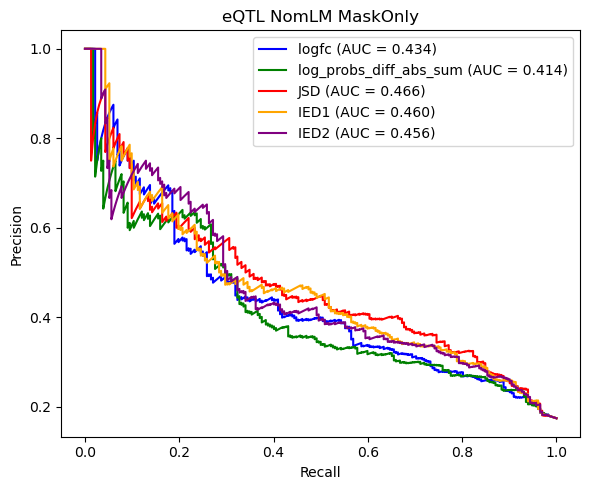

In [8]:
nomlm_maskonly = np.load('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/nomlm_maskonly.npy')
out_nomlm = predict_snp_effect_scores(nomlm_maskonly[:,:,0], nomlm_maskonly[:,:,1])
plot_metrics(out_nomlm, labels, 'eQTL NomLM MaskOnly')

In [11]:
#let's subset to only the ones that are non zero for enformer
(out[0] == 0).sum()

308

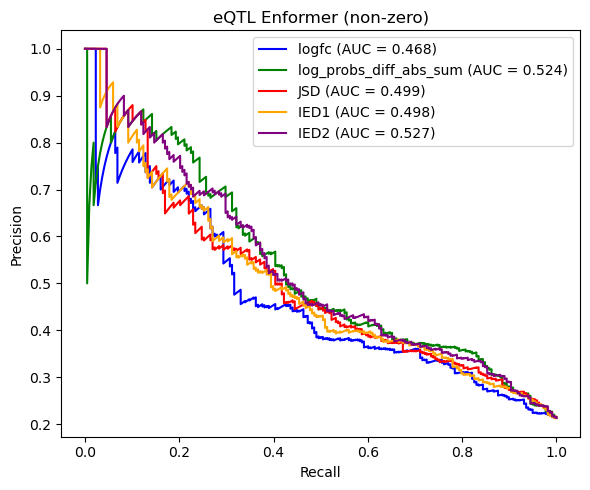

In [12]:
#308 need to be excluded lol
non_zero_mask = (out[0] != 0)
newout = [i[non_zero_mask] for i in out]
plot_metrics(newout, labels[non_zero_mask], 'eQTL Enformer (non-zero)')

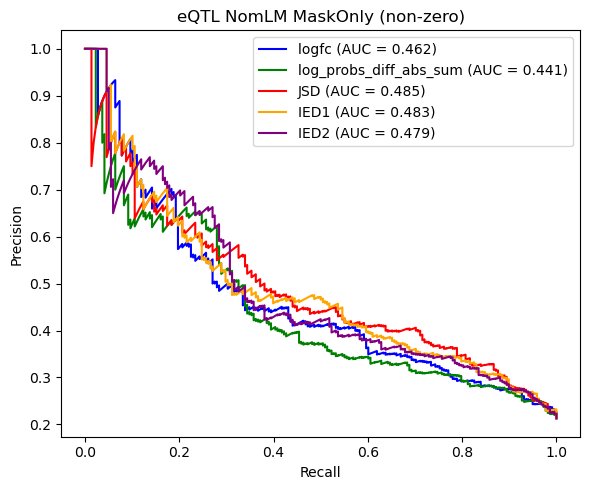

In [13]:
#and for nomlm
newout_nomlm = [i[non_zero_mask] for i in out_nomlm]
plot_metrics(newout_nomlm, labels[non_zero_mask], 'eQTL NomLM MaskOnly (non-zero)')

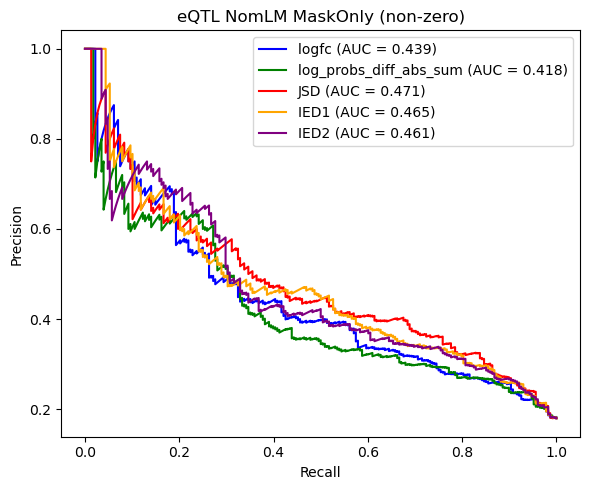

In [ ]:
#what if we can do nonzero for this one
non_zero_mask_nomlm = (out_nomlm[0] != 0)
newout_nomlm = [i[non_zero_mask_nomlm] for i in out_nomlm]
plot_metrics(newout_nomlm, labels[non_zero_mask_nomlm], 'eQTL NomLM MaskOnly (non-zero)') #harder cuz it's further away

# and redo but with the center areas only

In [15]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    """
    ref_prob_preds, alt_prob_preds: arrays of shape (N, L)
    returns five length-N arrays, with zeros for any row where both inputs are all-zero.
    """
    # 1) mask out rows where both ref & alt are entirely zero
    zero_mask = (ref_prob_preds.sum(axis=1) == 0) & (alt_prob_preds.sum(axis=1) == 0)
    valid    = ~zero_mask
    N        = ref_prob_preds.shape[0]
    
    # 2) prepare empty outputs
    logfc                    = np.zeros(N, dtype=float)
    log_probs_diff_abs_sum   = np.zeros(N, dtype=float)
    probs_jsd_diff           = np.zeros(N, dtype=float)
    integrative_effect_size  = np.zeros(N, dtype=float)
    integrative_effect_size2 = np.zeros(N, dtype=float)
    
    # 3) only compute on the valid rows
    if np.any(valid):
        r = ref_prob_preds[valid]
        a = alt_prob_preds[valid]
        
        # sum of absolute log-diffs
        lpd = np.sum(np.abs(np.log(a) - np.log(r)), axis=1)
        # Jensen-Shannon distance, one-by-one
        jsd = np.array([jensenshannon(x, y) for x,y in zip(a, r)])
        # log₂ fold-change of mean probabilities
        lf  = np.log2(r.mean(axis=1) / a.mean(axis=1))
        # two “integrative” sizes
        ies  = lf * jsd
        ies2 = lpd * jsd
        
        # 4) scatter them back into the full-size arrays
        log_probs_diff_abs_sum[valid]   = lpd
        probs_jsd_diff[valid]           = jsd
        logfc[valid]                    = lf
        integrative_effect_size[valid]  = ies
        integrative_effect_size2[valid] = ies2
    
    # 5) return—all-zero rows remain at zero
    return logfc, \
           log_probs_diff_abs_sum, \
           probs_jsd_diff, \
           integrative_effect_size, \
           integrative_effect_size2
           
def plot_metrics(out, labels, title):
    model_names = ['logfc', 'log_probs_diff_abs_sum', 'JSD', 'IED1', 'IED2']
    colors = ['blue', 'green', 'red', 'orange', 'purple']

    plt.figure(figsize=(6, 5))

    # # === ROC Curve ===
    # plt.subplot(1, 2, 1)
    # for i in range(len(model_names)):
    #     fpr, tpr, _ = roc_curve(labels, out[i])
    #     roc_auc = auc(fpr, tpr)
    #     plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.3f})', color=colors[i])

    # plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    # plt.title('ROC Curve')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.legend()

    # === Precision-Recall Curve ===
    # plt.subplot(1, 2, 2)
    for i in range(len(model_names)):
        precision, recall, _ = precision_recall_curve(labels, np.abs(out[i]))
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{model_names[i]} (AUC = {pr_auc:.3f})', color=colors[i])

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)
    plt.show()

qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/LCLs.txt', sep=' ', header=None)
qtls.columns = ['label', 'qtl_idx', 'gene_idx', 'chrom', 'gene_start', 'gene_end', 'strand', 'qtl_loc', 'ref', 'alt', 'sign_target']
labels = qtls['label'].to_numpy()


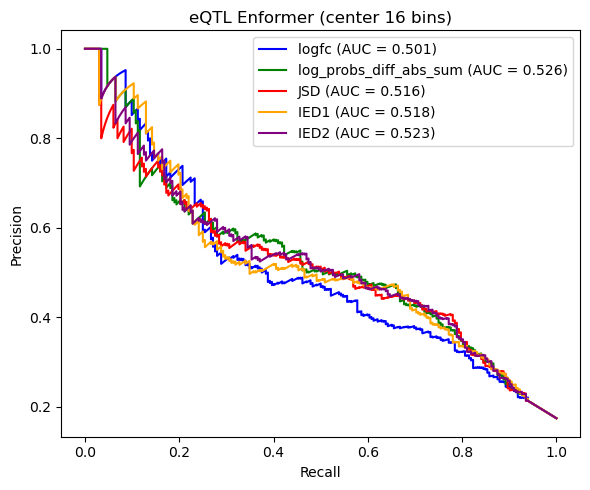

In [16]:
#let's do the center 16 bins of the 896
center_start = 896 // 2 - 16 // 2
center_end = center_start + 16
eqtl_enformer = np.load('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/enformer_eqtl.npy')[:, center_start:center_end, :]
out = predict_snp_effect_scores(eqtl_enformer[:, :, 0], eqtl_enformer[:, :, 1])
plot_metrics(out, labels, 'eQTL Enformer (center 16 bins)')

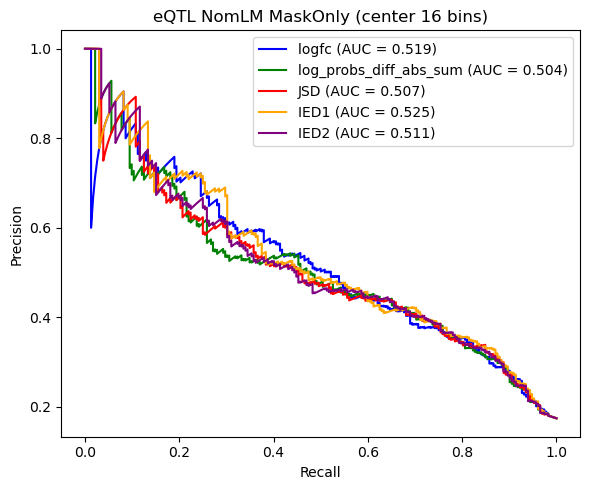

In [17]:
eqtl_nomlm_maskonly = np.load('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/nomlm_maskonly.npy')[:, center_start:center_end, :]
out_nomlm = predict_snp_effect_scores(eqtl_nomlm_maskonly[:, :, 0], eqtl_nomlm_maskonly[:, :, 1])
plot_metrics(out_nomlm, labels, 'eQTL NomLM MaskOnly (center 16 bins)')

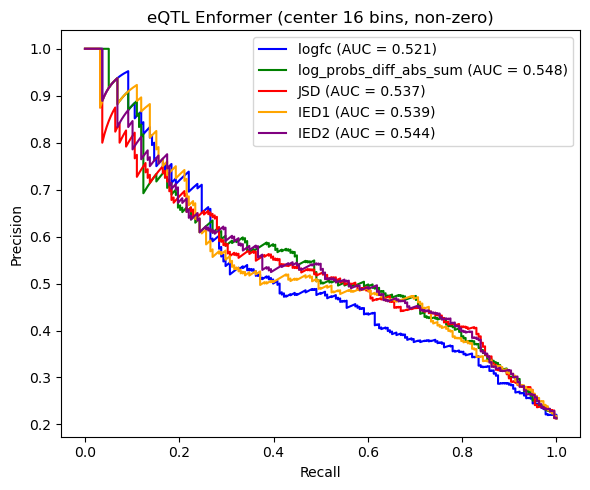

In [18]:
#and let's do the non-zero ones
non_zero_mask = (out[0] != 0)
newout = [i[non_zero_mask] for i in out]
plot_metrics(newout, labels[non_zero_mask], 'eQTL Enformer (center 16 bins, non-zero)')

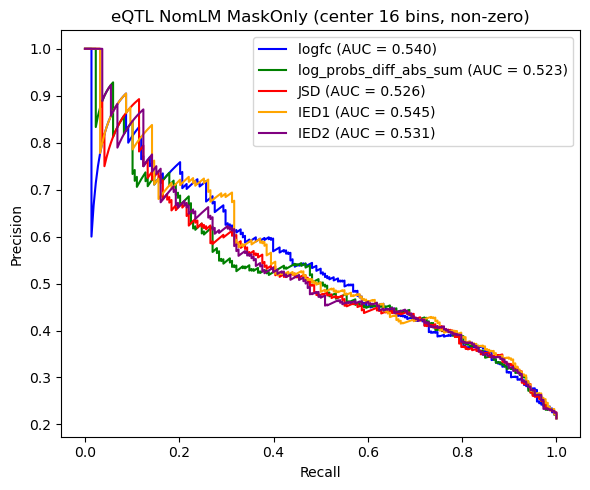

In [19]:
newout_nomlm = [i[non_zero_mask] for i in out_nomlm]
plot_metrics(newout_nomlm, labels[non_zero_mask], 'eQTL NomLM MaskOnly (center 16 bins, non-zero)')

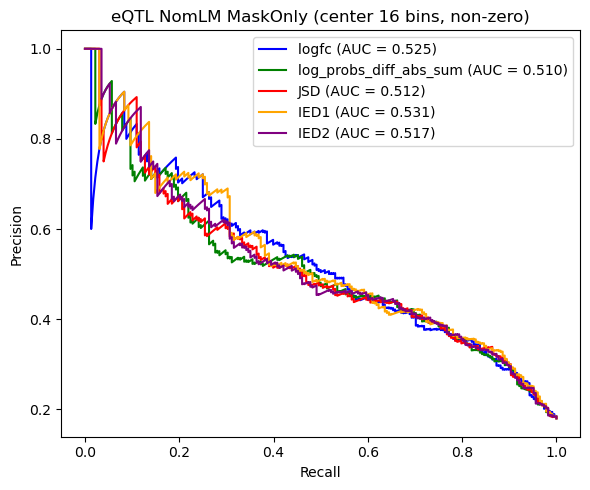

In [20]:
#and now let's do the same for nomlm
non_zero_mask_nomlm = (out_nomlm[0] != 0)
newout_nomlm = [i[non_zero_mask_nomlm] for i in out_nomlm]
plot_metrics(newout_nomlm, labels[non_zero_mask_nomlm], 'eQTL NomLM MaskOnly (center 16 bins, non-zero)') #harder cuz it's further away

# I realized we accidentally were using the DNase instead of the expression

In [3]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import numpy as np

def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    """
    ref_prob_preds, alt_prob_preds: arrays of shape (N, L)
    returns five length-N arrays, with zeros for any row where both inputs are all-zero.
    """
    # 1) mask out rows where both ref & alt are entirely zero
    zero_mask = (ref_prob_preds.sum(axis=1) == 0) & (alt_prob_preds.sum(axis=1) == 0)
    valid    = ~zero_mask
    N        = ref_prob_preds.shape[0]
    
    # 2) prepare empty outputs
    logfc                    = np.zeros(N, dtype=float)
    log_probs_diff_abs_sum   = np.zeros(N, dtype=float)
    probs_jsd_diff           = np.zeros(N, dtype=float)
    integrative_effect_size  = np.zeros(N, dtype=float)
    integrative_effect_size2 = np.zeros(N, dtype=float)
    
    # 3) only compute on the valid rows
    if np.any(valid):
        r = ref_prob_preds[valid]
        a = alt_prob_preds[valid]
        
        # sum of absolute log-diffs
        lpd = np.sum(np.abs(np.log(a) - np.log(r)), axis=1)
        # Jensen-Shannon distance, one-by-one
        jsd = np.array([jensenshannon(x, y) for x,y in zip(a, r)])
        # log₂ fold-change of mean probabilities
        lf  = np.log2(r.mean(axis=1) / a.mean(axis=1))
        # two “integrative” sizes
        ies  = lf * jsd
        ies2 = lpd * jsd
        
        # 4) scatter them back into the full-size arrays
        log_probs_diff_abs_sum[valid]   = lpd
        probs_jsd_diff[valid]           = jsd
        logfc[valid]                    = lf
        integrative_effect_size[valid]  = ies
        integrative_effect_size2[valid] = ies2
    
    # 5) return—all-zero rows remain at zero
    return logfc, \
           log_probs_diff_abs_sum, \
           probs_jsd_diff, \
           integrative_effect_size, \
           integrative_effect_size2
           
def plot_metrics(out, labels, title):
    model_names = ['logfc', 'log_probs_diff_abs_sum', 'JSD', 'IED1', 'IED2']
    colors = ['blue', 'green', 'red', 'orange', 'purple']

    plt.figure(figsize=(6, 5))

    # # === ROC Curve ===
    # plt.subplot(1, 2, 1)
    # for i in range(len(model_names)):
    #     fpr, tpr, _ = roc_curve(labels, out[i])
    #     roc_auc = auc(fpr, tpr)
    #     plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.3f})', color=colors[i])

    # plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    # plt.title('ROC Curve')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.legend()

    # === Precision-Recall Curve ===
    # plt.subplot(1, 2, 2)
    for i in range(len(model_names)):
        precision, recall, _ = precision_recall_curve(labels, np.abs(out[i]))
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{model_names[i]} (AUC = {pr_auc:.3f})', color=colors[i])

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)
    plt.show()

qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/LCLs.txt', sep=' ', header=None)
qtls.columns = ['label', 'qtl_idx', 'gene_idx', 'chrom', 'gene_start', 'gene_end', 'strand', 'qtl_loc', 'ref', 'alt', 'sign_target']
labels = qtls['label'].to_numpy()


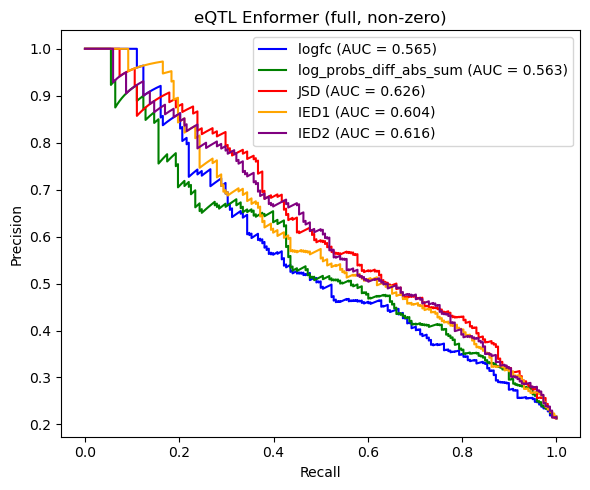

In [11]:
#let's first do it without the center
eqtl_enformer = np.load('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/enformer_eqtl.npy')
out = predict_snp_effect_scores(eqtl_enformer[:, :, 0], eqtl_enformer[:, :, 1])
non_zero_mask = (out[0] != 0)
newout = [i[non_zero_mask] for i in out]
plot_metrics(newout, labels[non_zero_mask], 'eQTL Enformer (full, non-zero)')

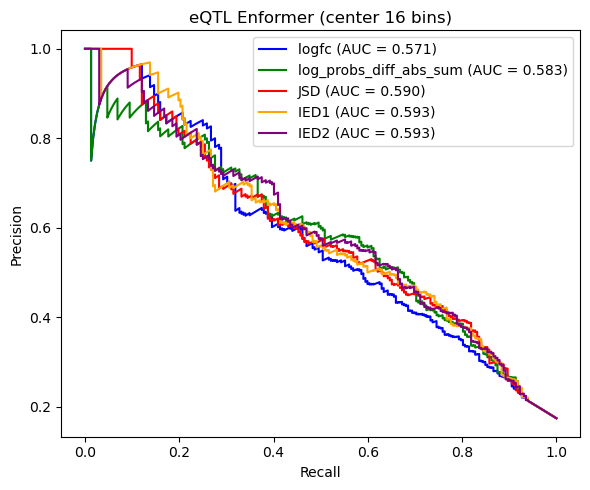

In [4]:
#let's do the center 16 bins of the 896
center_start = 896 // 2 - 16 // 2
center_end = center_start + 16
eqtl_enformer = np.load('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/enformer_eqtl.npy')[:, center_start:center_end, :]
out = predict_snp_effect_scores(eqtl_enformer[:, :, 0], eqtl_enformer[:, :, 1])
plot_metrics(out, labels, 'eQTL Enformer (center 16 bins)')

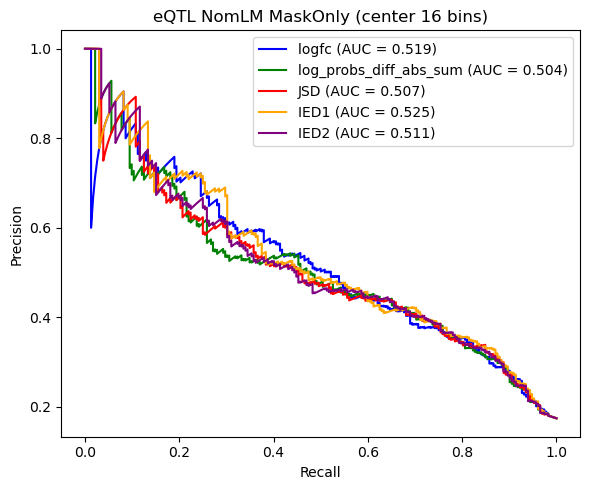

In [5]:
eqtl_nomlm_maskonly = np.load('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/nomlm_maskonly.npy')[:, center_start:center_end, :]
out_nomlm = predict_snp_effect_scores(eqtl_nomlm_maskonly[:, :, 0], eqtl_nomlm_maskonly[:, :, 1])
plot_metrics(out_nomlm, labels, 'eQTL NomLM MaskOnly (center 16 bins)')

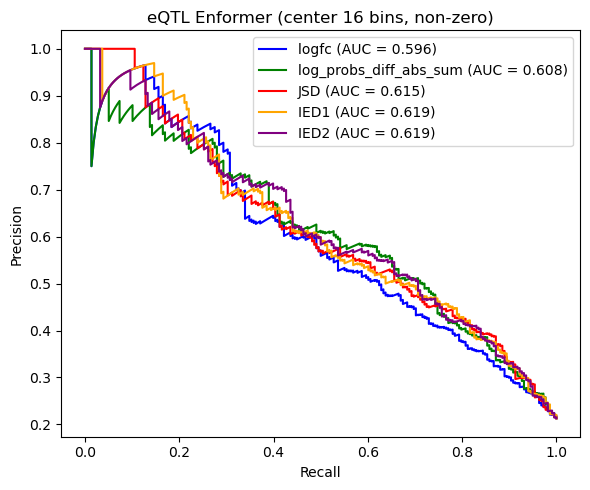

In [6]:
#and let's do the non-zero ones
non_zero_mask = (out[0] != 0)
newout = [i[non_zero_mask] for i in out]
plot_metrics(newout, labels[non_zero_mask], 'eQTL Enformer (center 16 bins, non-zero)')

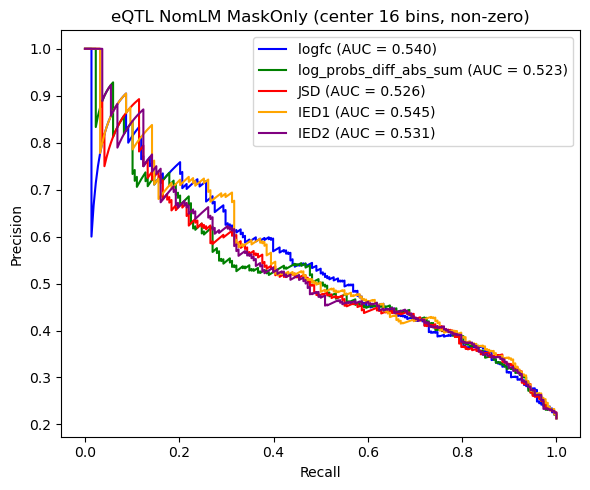

In [7]:
newout_nomlm = [i[non_zero_mask] for i in out_nomlm]
plot_metrics(newout_nomlm, labels[non_zero_mask], 'eQTL NomLM MaskOnly (center 16 bins, non-zero)')

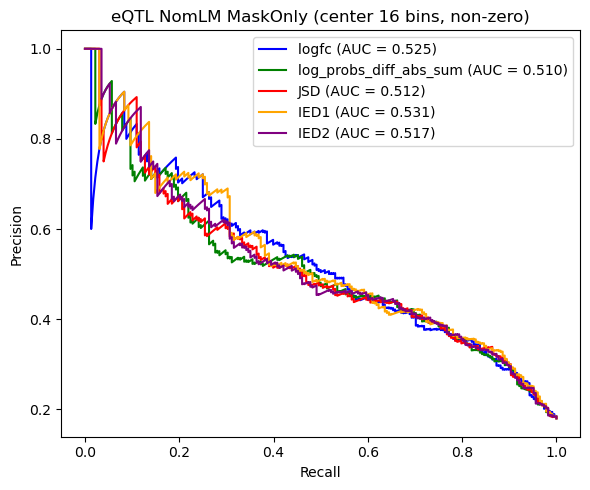

In [8]:
#and now let's do the same for nomlm
non_zero_mask_nomlm = (out_nomlm[0] != 0)
newout_nomlm = [i[non_zero_mask_nomlm] for i in out_nomlm]
plot_metrics(newout_nomlm, labels[non_zero_mask_nomlm], 'eQTL NomLM MaskOnly (center 16 bins, non-zero)') #harder cuz it's further away

# we have some more models

In [12]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    """
    ref_prob_preds, alt_prob_preds: arrays of shape (N, L)
    returns five length-N arrays, with zeros for any row where both inputs are all-zero.
    """
    # 1) mask out rows where both ref & alt are entirely zero
    zero_mask = (ref_prob_preds.sum(axis=1) == 0) & (alt_prob_preds.sum(axis=1) == 0)
    valid    = ~zero_mask
    N        = ref_prob_preds.shape[0]
    
    # 2) prepare empty outputs
    logfc                    = np.zeros(N, dtype=float)
    log_probs_diff_abs_sum   = np.zeros(N, dtype=float)
    probs_jsd_diff           = np.zeros(N, dtype=float)
    integrative_effect_size  = np.zeros(N, dtype=float)
    integrative_effect_size2 = np.zeros(N, dtype=float)
    
    # 3) only compute on the valid rows
    if np.any(valid):
        r = ref_prob_preds[valid]
        a = alt_prob_preds[valid]
        
        # sum of absolute log-diffs
        lpd = np.sum(np.abs(np.log(a) - np.log(r)), axis=1)
        # Jensen-Shannon distance, one-by-one
        jsd = np.array([jensenshannon(x, y) for x,y in zip(a, r)])
        # log₂ fold-change of mean probabilities
        lf  = np.log2(r.mean(axis=1) / a.mean(axis=1))
        # two “integrative” sizes
        ies  = lf * jsd
        ies2 = lpd * jsd
        
        # 4) scatter them back into the full-size arrays
        log_probs_diff_abs_sum[valid]   = lpd
        probs_jsd_diff[valid]           = jsd
        logfc[valid]                    = lf
        integrative_effect_size[valid]  = ies
        integrative_effect_size2[valid] = ies2
    
    # 5) return—all-zero rows remain at zero
    return logfc, \
           log_probs_diff_abs_sum, \
           probs_jsd_diff, \
           integrative_effect_size, \
           integrative_effect_size2
           
def plot_metrics(out, labels, title):
    model_names = ['logfc', 'log_probs_diff_abs_sum', 'JSD', 'IED1', 'IED2']
    colors = ['blue', 'green', 'red', 'orange', 'purple']

    plt.figure(figsize=(6, 5))

    # # === ROC Curve ===
    # plt.subplot(1, 2, 1)
    # for i in range(len(model_names)):
    #     fpr, tpr, _ = roc_curve(labels, out[i])
    #     roc_auc = auc(fpr, tpr)
    #     plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.3f})', color=colors[i])

    # plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    # plt.title('ROC Curve')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.legend()

    # === Precision-Recall Curve ===
    # plt.subplot(1, 2, 2)
    for i in range(len(model_names)):
        precision, recall, _ = precision_recall_curve(labels, np.abs(out[i]))
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{model_names[i]} (AUC = {pr_auc:.3f})', color=colors[i])

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)
    plt.show()

qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/LCLs.txt', sep=' ', header=None)
qtls.columns = ['label', 'qtl_idx', 'gene_idx', 'chrom', 'gene_start', 'gene_end', 'strand', 'qtl_loc', 'ref', 'alt', 'sign_target']
labels = qtls['label'].to_numpy()


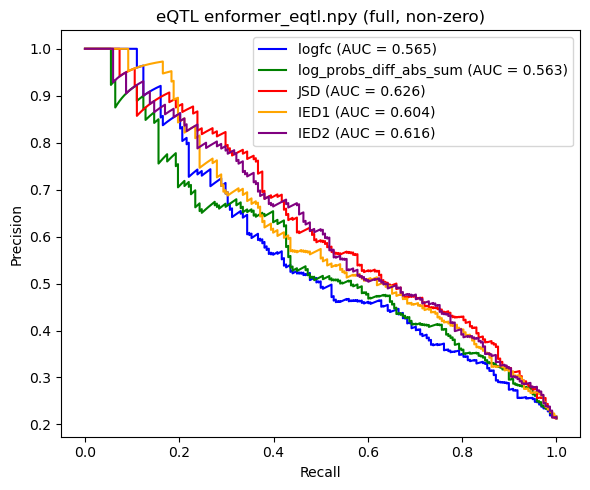

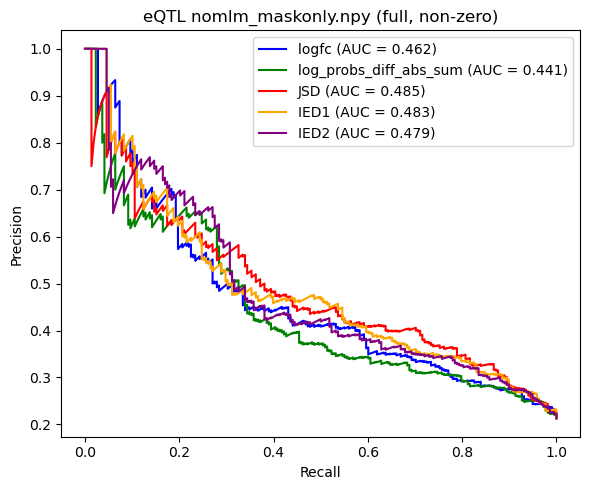

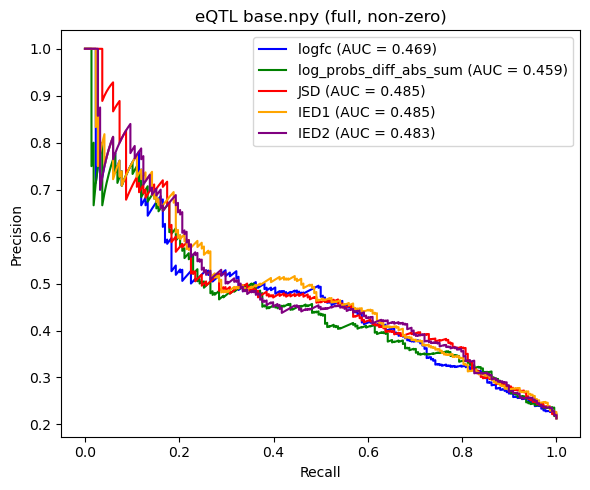

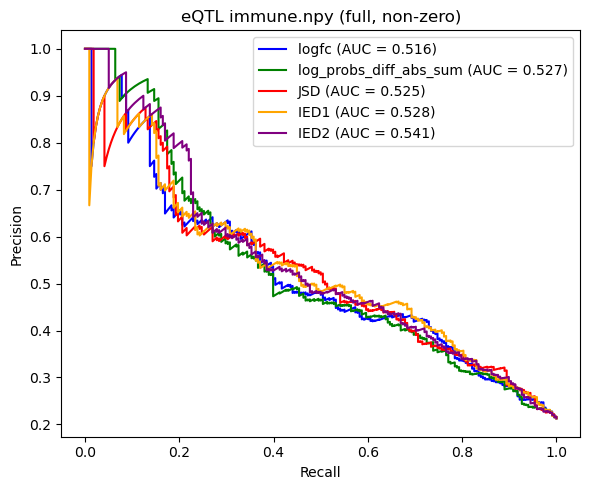

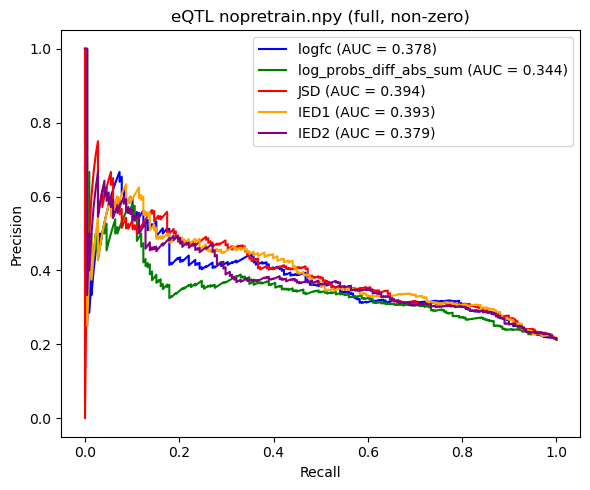

In [14]:
files = ['enformer_eqtl.npy', 'nomlm_maskonly.npy', 'base.npy', 'immune.npy', 'nopretrain.npy']
eqtl_enformer = np.load('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/enformer_eqtl.npy')
out = predict_snp_effect_scores(eqtl_enformer[:, :, 0], eqtl_enformer[:, :, 1])
non_zero_mask = (out[0] != 0)

for file in files:
    eqtl_enformer = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{file}')
    out = predict_snp_effect_scores(eqtl_enformer[:, :, 0], eqtl_enformer[:, :, 1])
    newout = [i[non_zero_mask] for i in out]
    plot_metrics(newout, labels[non_zero_mask], f'eQTL {file} (full, non-zero)')

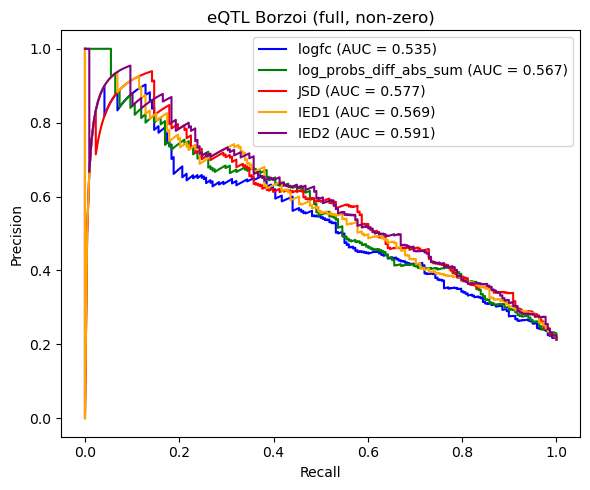

In [15]:
#let's also check borzoi
borzoi_eqtl = np.load('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/borzoi_eqtl.npy')
out_borzoi = predict_snp_effect_scores(borzoi_eqtl[:, :, 0], borzoi_eqtl[:, :, 1])
newout_borzoi = [i[non_zero_mask] for i in out_borzoi]
plot_metrics(newout_borzoi, labels[non_zero_mask], 'eQTL Borzoi (full, non-zero)')

In [16]:
borzoi_eqtl.shape

(1331, 6144, 2)

In [19]:
#let's pool it now!
borzoi_pooled = borzoi_eqtl.reshape(borzoi_eqtl.shape[0], 1536, 4, 2).mean(axis=2)
borzoi_pooled.shape

(1331, 1536, 2)

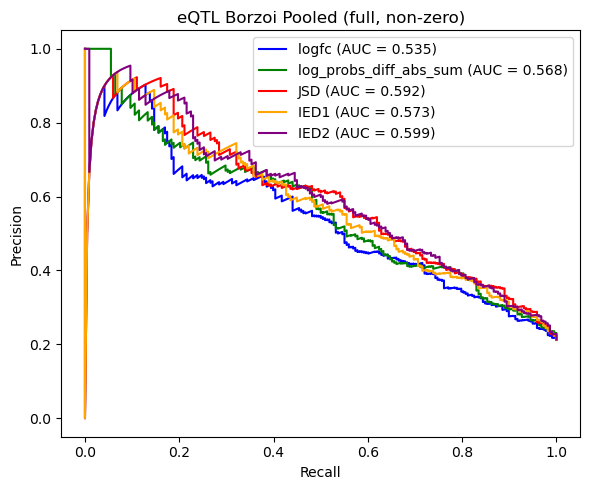

In [20]:
#now we can do it again
out_borzoi_pooled = predict_snp_effect_scores(borzoi_pooled[:, :, 0], borzoi_pooled[:, :, 1])
newout_borzoi_pooled = [i[non_zero_mask] for i in out_borzoi_pooled]
plot_metrics(newout_borzoi_pooled, labels[non_zero_mask], 'eQTL Borzoi Pooled (full, non-zero)')

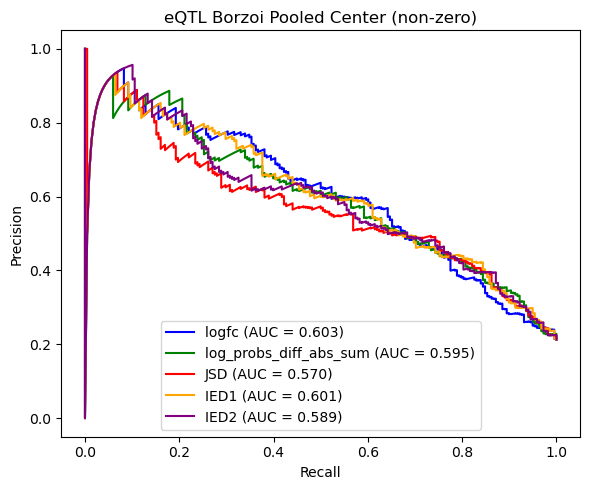

In [22]:
#and center to the middle 16 bins
center_start = 1536 // 2 - 16 // 2
center_end = center_start + 16
borzoi_pooled_center = borzoi_pooled[:, center_start:center_end, :]
out_borzoi_pooled_center = predict_snp_effect_scores(borzoi_pooled_center[:, :, 0], borzoi_pooled_center[:, :, 1])
newout_borzoi_pooled_center = [i[non_zero_mask] for i in out_borzoi_pooled_center]
plot_metrics(newout_borzoi_pooled_center, labels[non_zero_mask], 'eQTL Borzoi Pooled Center (non-zero)')

In [ ]:
#not an improvement really, this is interesting!

# let's do it again with some more models

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    """
    ref_prob_preds, alt_prob_preds: arrays of shape (N, L)
    returns five length-N arrays, with zeros for any row where both inputs are all-zero.
    """
    # 1) mask out rows where both ref & alt are entirely zero
    zero_mask = (ref_prob_preds.sum(axis=1) == 0) & (alt_prob_preds.sum(axis=1) == 0)
    valid    = ~zero_mask
    N        = ref_prob_preds.shape[0]
    
    # 2) prepare empty outputs
    logfc                    = np.zeros(N, dtype=float)
    log_probs_diff_abs_sum   = np.zeros(N, dtype=float)
    probs_jsd_diff           = np.zeros(N, dtype=float)
    integrative_effect_size  = np.zeros(N, dtype=float)
    integrative_effect_size2 = np.zeros(N, dtype=float)
    
    # 3) only compute on the valid rows
    if np.any(valid):
        r = ref_prob_preds[valid]
        a = alt_prob_preds[valid]
        
        # sum of absolute log-diffs
        lpd = np.sum(np.abs(np.log(a) - np.log(r)), axis=1)
        # Jensen-Shannon distance, one-by-one
        jsd = np.array([jensenshannon(x, y) for x,y in zip(a, r)])
        # log₂ fold-change of mean probabilities
        lf  = np.log2(r.mean(axis=1) / a.mean(axis=1))
        # two “integrative” sizes
        ies  = lf * jsd
        ies2 = lpd * jsd
        
        # 4) scatter them back into the full-size arrays
        log_probs_diff_abs_sum[valid]   = lpd
        probs_jsd_diff[valid]           = jsd
        logfc[valid]                    = lf
        integrative_effect_size[valid]  = ies
        integrative_effect_size2[valid] = ies2
    
    # 5) return—all-zero rows remain at zero
    return logfc, \
           log_probs_diff_abs_sum, \
           probs_jsd_diff, \
           integrative_effect_size, \
           integrative_effect_size2
           
def plot_metrics(out, labels, title):
    model_names = ['logfc', 'log_probs_diff_abs_sum', 'JSD', 'IED1', 'IED2']
    colors = ['blue', 'green', 'red', 'orange', 'purple']

    plt.figure(figsize=(6, 5))


    for i in range(len(model_names)):
        precision, recall, _ = precision_recall_curve(labels, np.abs(out[i]))
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{model_names[i]} (AUC = {pr_auc:.3f})', color=colors[i])

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)
    plt.show()

qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/LCLs.txt', sep=' ', header=None)
qtls.columns = ['label', 'qtl_idx', 'gene_idx', 'chrom', 'gene_start', 'gene_end', 'strand', 'qtl_loc', 'ref', 'alt', 'sign_target']
labels = qtls['label'].to_numpy()


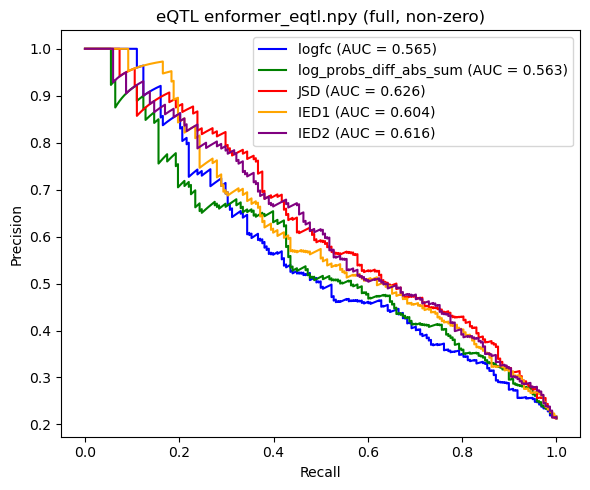

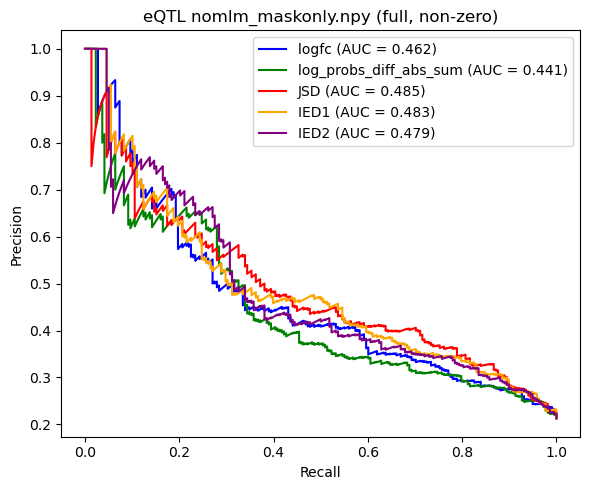

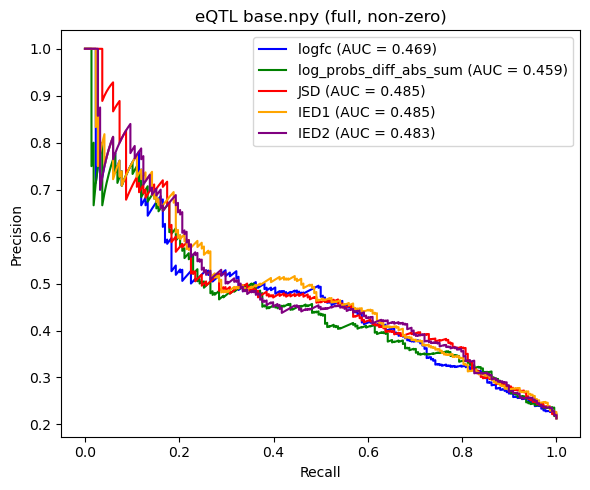

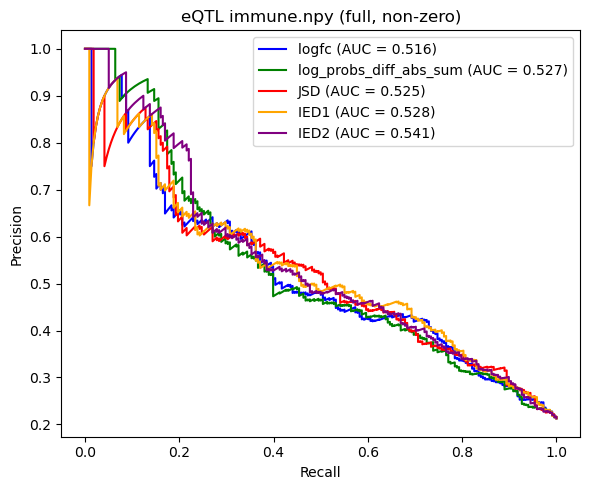

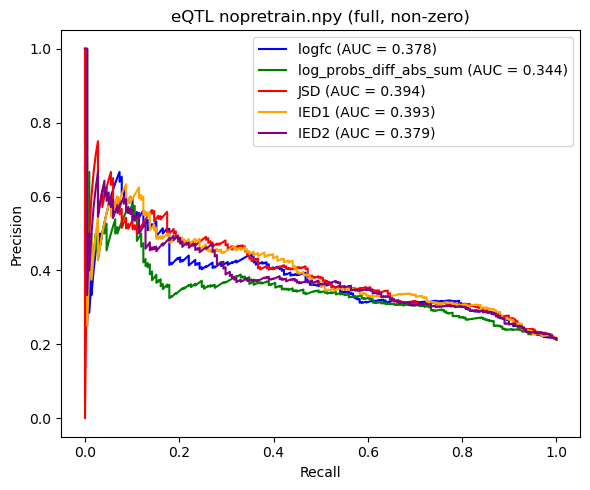

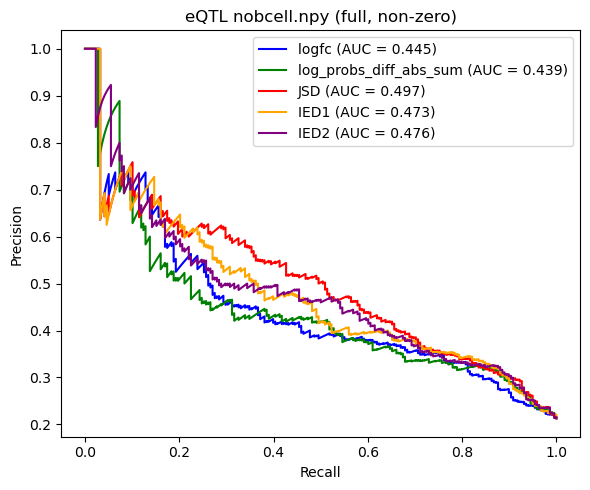

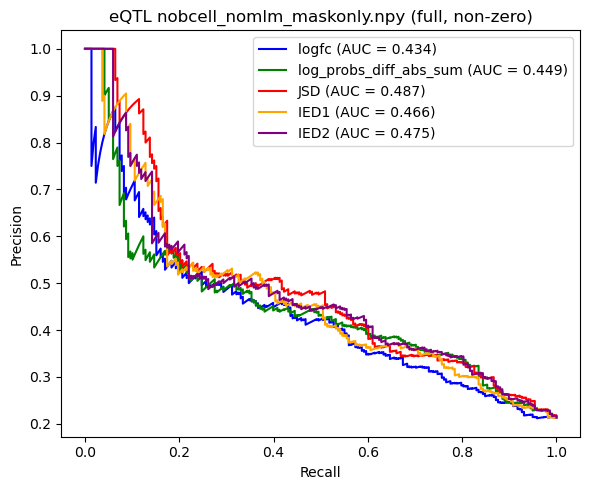

In [ ]:
files = ['enformer_eqtl.npy', 'nomlm_maskonly.npy', 'base.npy', 'immune.npy', 'nopretrain.npy', 'nobcell.npy', 'nobcell_nomlm_maskonly.npy']
eqtl_enformer = np.load('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/enformer_eqtl.npy')
out = predict_snp_effect_scores(eqtl_enformer[:, :, 0], eqtl_enformer[:, :, 1])
non_zero_mask = (out[0] != 0)

for file in files:
    eqtl_enformer = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{file}')
    out = predict_snp_effect_scores(eqtl_enformer[:, :, 0], eqtl_enformer[:, :, 1])
    newout = [i[non_zero_mask] for i in out]
    plot_metrics(newout, labels[non_zero_mask], f'eQTL {file} (full, non-zero)')

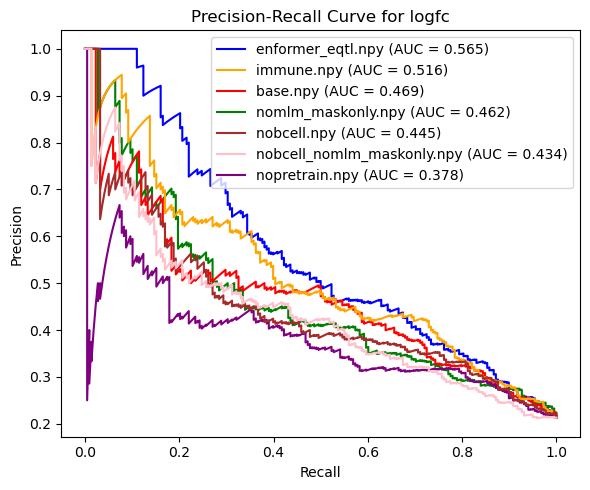

In [5]:
def plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False):
    metric_index_map = {
        'logfc': 0,
        'log_probs_diff_abs_sum': 1,
        'JSD': 2,
        'IED1': 3,
        'IED2': 4
    }
    assert metric_name in metric_index_map, f"Invalid metric: {metric_name}"
    metric_idx = metric_index_map[metric_name]

    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    plt.figure(figsize=(6, 5))
    legend_entries = []

    for i, file in enumerate(files):
        eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{file}')
        out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])

        if i == 0:
            non_zero_mask = (out[0] != 0)

        selected_metric = np.abs(out[metric_idx])[non_zero_mask]
        precision, recall, _ = precision_recall_curve(labels[non_zero_mask], selected_metric)
        pr_auc = auc(recall, precision)

        line, = plt.plot(recall, precision, label=file, color=colors[i % len(colors)])
        legend_entries.append((pr_auc, line, f'{file} (AUC = {pr_auc:.3f})'))

    plt.title(f'Precision-Recall Curve for {metric_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    if sort_legend_by_auc:
        legend_entries.sort(reverse=True, key=lambda x: x[0])  # sort by AUC descending
    handles = [entry[1] for entry in legend_entries]
    labels_sorted = [entry[2] for entry in legend_entries]

    plt.legend(handles, labels_sorted)
    plt.tight_layout()
    plt.show()

plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=True)

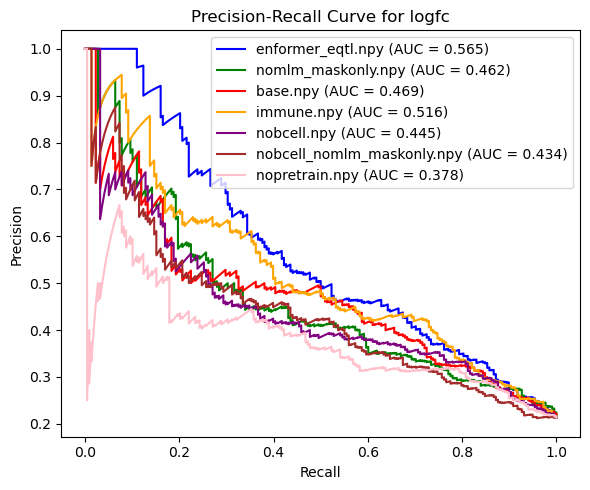

In [8]:
files = ['enformer_eqtl.npy', 'nomlm_maskonly.npy', 'base.npy', 'immune.npy', 'nobcell.npy', 'nobcell_nomlm_maskonly.npy', 'nopretrain.npy']
plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False)

# redoing this for the center bins

In [10]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    """
    ref_prob_preds, alt_prob_preds: arrays of shape (N, L)
    returns five length-N arrays, with zeros for any row where both inputs are all-zero.
    """
    # 1) mask out rows where both ref & alt are entirely zero
    zero_mask = (ref_prob_preds.sum(axis=1) == 0) & (alt_prob_preds.sum(axis=1) == 0)
    valid    = ~zero_mask
    N        = ref_prob_preds.shape[0]
    
    # 2) prepare empty outputs
    logfc                    = np.zeros(N, dtype=float)
    log_probs_diff_abs_sum   = np.zeros(N, dtype=float)
    probs_jsd_diff           = np.zeros(N, dtype=float)
    integrative_effect_size  = np.zeros(N, dtype=float)
    integrative_effect_size2 = np.zeros(N, dtype=float)
    
    # 3) only compute on the valid rows
    if np.any(valid):
        r = ref_prob_preds[valid]
        a = alt_prob_preds[valid]
        
        # sum of absolute log-diffs
        lpd = np.sum(np.abs(np.log(a) - np.log(r)), axis=1)
        # Jensen-Shannon distance, one-by-one
        jsd = np.array([jensenshannon(x, y) for x,y in zip(a, r)])
        # log₂ fold-change of mean probabilities
        lf  = np.log2(r.mean(axis=1) / a.mean(axis=1))
        # two “integrative” sizes
        ies  = lf * jsd
        ies2 = lpd * jsd
        
        # 4) scatter them back into the full-size arrays
        log_probs_diff_abs_sum[valid]   = lpd
        probs_jsd_diff[valid]           = jsd
        logfc[valid]                    = lf
        integrative_effect_size[valid]  = ies
        integrative_effect_size2[valid] = ies2
    
    # 5) return—all-zero rows remain at zero
    return logfc, \
           log_probs_diff_abs_sum, \
           probs_jsd_diff, \
           integrative_effect_size, \
           integrative_effect_size2
           
def plot_metrics(out, labels, title):
    model_names = ['logfc', 'log_probs_diff_abs_sum', 'JSD', 'IED1', 'IED2']
    colors = ['blue', 'green', 'red', 'orange', 'purple']

    plt.figure(figsize=(6, 5))


    for i in range(len(model_names)):
        precision, recall, _ = precision_recall_curve(labels, np.abs(out[i]))
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{model_names[i]} (AUC = {pr_auc:.3f})', color=colors[i])

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)
    plt.show()
    
def plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, center=False, title=''):
    metric_index_map = {
        'logfc': 0,
        'log_probs_diff_abs_sum': 1,
        'JSD': 2,
        'IED1': 3,
        'IED2': 4
    }
    assert metric_name in metric_index_map, f"Invalid metric: {metric_name}"
    metric_idx = metric_index_map[metric_name]

    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    plt.figure(figsize=(6, 5))
    legend_entries = []

    for i, file in enumerate(files):
        eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{file}')
        if center:
            center_start = eqtl_data.shape[1] // 2 - 16 // 2
            center_end = center_start + 16
            eqtl_data = eqtl_data[:, center_start:center_end, :]
        out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])

        if i == 0:
            non_zero_mask = (out[0] != 0)

        selected_metric = np.abs(out[metric_idx])[non_zero_mask]
        precision, recall, _ = precision_recall_curve(labels[non_zero_mask], selected_metric)
        pr_auc = auc(recall, precision)

        line, = plt.plot(recall, precision, label=file, color=colors[i % len(colors)])
        legend_entries.append((pr_auc, line, f'{file} (AUC = {pr_auc:.3f})'))

    plt.title(f'Precision-Recall Curve for {metric_name} {title}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    if sort_legend_by_auc:
        legend_entries.sort(reverse=True, key=lambda x: x[0])  # sort by AUC descending
    handles = [entry[1] for entry in legend_entries]
    labels_sorted = [entry[2] for entry in legend_entries]

    plt.legend(handles, labels_sorted)
    plt.tight_layout()
    plt.show()


qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/LCLs.txt', sep=' ', header=None)
qtls.columns = ['label', 'qtl_idx', 'gene_idx', 'chrom', 'gene_start', 'gene_end', 'strand', 'qtl_loc', 'ref', 'alt', 'sign_target']
labels = qtls['label'].to_numpy()

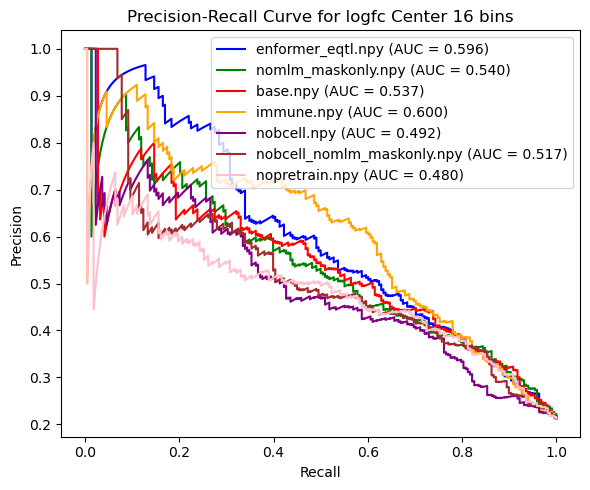

In [12]:
#let's now do the plot, but center it and 
files = ['enformer_eqtl.npy', 'nomlm_maskonly.npy', 'base.npy', 'immune.npy', 'nobcell.npy', 'nobcell_nomlm_maskonly.npy', 'nopretrain.npy']
plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, center=True, title='Center 16 bins')

# doing it for more models

keep the previous the same so that we can compare easier

In [1]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    """
    ref_prob_preds, alt_prob_preds: arrays of shape (N, L)
    returns five length-N arrays, with zeros for any row where both inputs are all-zero.
    """
    # 1) mask out rows where both ref & alt are entirely zero
    zero_mask = (ref_prob_preds.sum(axis=1) == 0) & (alt_prob_preds.sum(axis=1) == 0)
    valid    = ~zero_mask
    N        = ref_prob_preds.shape[0]
    
    # 2) prepare empty outputs
    logfc                    = np.zeros(N, dtype=float)
    log_probs_diff_abs_sum   = np.zeros(N, dtype=float)
    probs_jsd_diff           = np.zeros(N, dtype=float)
    integrative_effect_size  = np.zeros(N, dtype=float)
    integrative_effect_size2 = np.zeros(N, dtype=float)
    
    # 3) only compute on the valid rows
    if np.any(valid):
        r = ref_prob_preds[valid]
        a = alt_prob_preds[valid]
        
        # sum of absolute log-diffs
        lpd = np.sum(np.abs(np.log(a) - np.log(r)), axis=1)
        # Jensen-Shannon distance, one-by-one
        jsd = np.array([jensenshannon(x, y) for x,y in zip(a, r)])
        # log₂ fold-change of mean probabilities
        lf  = np.log2(r.mean(axis=1) / a.mean(axis=1))
        # two “integrative” sizes
        ies  = lf * jsd
        ies2 = lpd * jsd
        
        # 4) scatter them back into the full-size arrays
        log_probs_diff_abs_sum[valid]   = lpd
        probs_jsd_diff[valid]           = jsd
        logfc[valid]                    = lf
        integrative_effect_size[valid]  = ies
        integrative_effect_size2[valid] = ies2
    
    # 5) return—all-zero rows remain at zero
    return logfc, \
           log_probs_diff_abs_sum, \
           probs_jsd_diff, \
           integrative_effect_size, \
           integrative_effect_size2
           
def plot_metrics(out, labels, title):
    model_names = ['logfc', 'log_probs_diff_abs_sum', 'JSD', 'IED1', 'IED2']
    colors = ['blue', 'green', 'red', 'orange', 'purple']

    plt.figure(figsize=(6, 5))


    for i in range(len(model_names)):
        precision, recall, _ = precision_recall_curve(labels, np.abs(out[i]))
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{model_names[i]} (AUC = {pr_auc:.3f})', color=colors[i])

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)
    plt.show()

qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/LCLs.txt', sep=' ', header=None)
qtls.columns = ['label', 'qtl_idx', 'gene_idx', 'chrom', 'gene_start', 'gene_end', 'strand', 'qtl_loc', 'ref', 'alt', 'sign_target']
labels = qtls['label'].to_numpy()


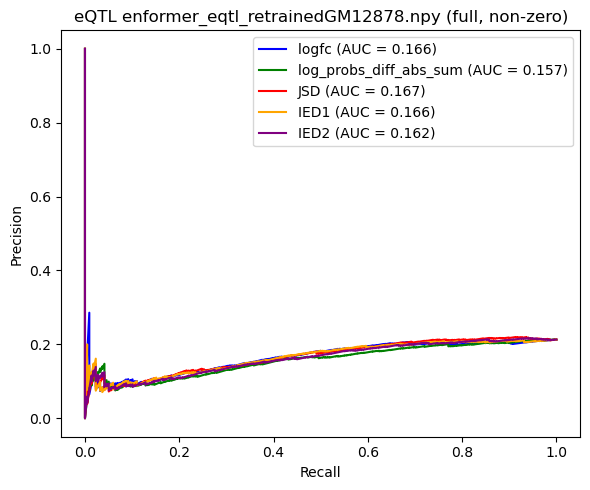

In [3]:
files = ['enformer_eqtl_retrainedGM12878.npy']
eqtl_enformer = np.load('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/enformer_eqtl.npy')
out = predict_snp_effect_scores(eqtl_enformer[:, :, 0], eqtl_enformer[:, :, 1])
non_zero_mask = (out[0] != 0)

for file in files:
    eqtl_enformer = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{file}')
    out = predict_snp_effect_scores(eqtl_enformer[:, :, 0], eqtl_enformer[:, :, 1])
    newout = [i[non_zero_mask] for i in out]
    plot_metrics(newout, labels[non_zero_mask], f'eQTL {file} (full, non-zero)')

# stratifying by distance

In [2]:
#we want to see as the TSS gets further away which models perform better

from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    """
    ref_prob_preds, alt_prob_preds: arrays of shape (N, L)
    returns five length-N arrays, with zeros for any row where both inputs are all-zero.
    """
    # 1) mask out rows where both ref & alt are entirely zero
    zero_mask = (ref_prob_preds.sum(axis=1) == 0) & (alt_prob_preds.sum(axis=1) == 0)
    valid    = ~zero_mask
    N        = ref_prob_preds.shape[0]
    
    # 2) prepare empty outputs
    logfc                    = np.zeros(N, dtype=float)
    log_probs_diff_abs_sum   = np.zeros(N, dtype=float)
    probs_jsd_diff           = np.zeros(N, dtype=float)
    integrative_effect_size  = np.zeros(N, dtype=float)
    integrative_effect_size2 = np.zeros(N, dtype=float)
    
    # 3) only compute on the valid rows
    if np.any(valid):
        r = ref_prob_preds[valid]
        a = alt_prob_preds[valid]
        
        # sum of absolute log-diffs
        lpd = np.sum(np.abs(np.log(a) - np.log(r)), axis=1)
        # Jensen-Shannon distance, one-by-one
        jsd = np.array([jensenshannon(x, y) for x,y in zip(a, r)])
        # log₂ fold-change of mean probabilities
        lf  = np.log2(r.mean(axis=1) / a.mean(axis=1))
        # two “integrative” sizes
        ies  = lf * jsd
        ies2 = lpd * jsd
        
        # 4) scatter them back into the full-size arrays
        log_probs_diff_abs_sum[valid]   = lpd
        probs_jsd_diff[valid]           = jsd
        logfc[valid]                    = lf
        integrative_effect_size[valid]  = ies
        integrative_effect_size2[valid] = ies2
    
    # 5) return—all-zero rows remain at zero
    return logfc, \
           log_probs_diff_abs_sum, \
           probs_jsd_diff, \
           integrative_effect_size, \
           integrative_effect_size2
           
qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/LCLs.txt', sep=' ', header=None)
qtls.columns = ['label', 'qtl_idx', 'gene_idx', 'chrom', 'gene_start', 'gene_end', 'strand', 'qtl_loc', 'ref', 'alt', 'sign_target']
labels = qtls['label'].to_numpy()



In [3]:
#let's now grab the data on the distance to the TSS
import pickle
base_dir = '/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/'
with open(base_dir+'genes.pickle', 'rb') as f:
    gene_annotation = pickle.load(f)

ordered_genes = sorted(list(gene_annotation.keys()))

tmpgeneTSS = np.loadtxt(base_dir+'ensemblTSS.txt', dtype='str')
geneTSS_dic = {tmpgeneTSS[i, 0]: int(tmpgeneTSS[i, 1]) for i in range(tmpgeneTSS.shape[0])}

distances = np.zeros((qtls.shape[0],), dtype=int)

for i in range(qtls.shape[0]):
    #initialize values and load in data
    temp = qtls.iloc[i]
    chrom   = 'chrX' if temp['chrom']==23 else 'chr'+str(temp['chrom'])
    pos     = temp['qtl_loc'] - 1  # Convert to zero-based index
    gene_idx= temp['gene_idx']
    tss_loc = geneTSS_dic[ordered_genes[gene_idx]]
    # print(tss_loc, pos)
    distances[i] = abs(tss_loc - pos)    

In [4]:
distances

array([    8,    63,   638, ..., 30381,   708,   171])

In [ ]:
#let's set some thresholds

from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt

def predict_snp_effect_scores(ref_prob_preds, alt_prob_preds):
    """
    ref_prob_preds, alt_prob_preds: arrays of shape (N, L)
    returns five length-N arrays, with zeros for any row where both inputs are all-zero.
    """
    # 1) mask out rows where both ref & alt are entirely zero
    zero_mask = (ref_prob_preds.sum(axis=1) == 0) & (alt_prob_preds.sum(axis=1) == 0)
    valid    = ~zero_mask
    N        = ref_prob_preds.shape[0]
    
    # 2) prepare empty outputs
    logfc                    = np.zeros(N, dtype=float)
    log_probs_diff_abs_sum   = np.zeros(N, dtype=float)
    probs_jsd_diff           = np.zeros(N, dtype=float)
    integrative_effect_size  = np.zeros(N, dtype=float)
    integrative_effect_size2 = np.zeros(N, dtype=float)
    
    # 3) only compute on the valid rows
    if np.any(valid):
        r = ref_prob_preds[valid]
        a = alt_prob_preds[valid]
        
        # sum of absolute log-diffs
        lpd = np.sum(np.abs(np.log(a) - np.log(r)), axis=1)
        # Jensen-Shannon distance, one-by-one
        jsd = np.array([jensenshannon(x, y) for x,y in zip(a, r)])
        # log₂ fold-change of mean probabilities
        lf  = np.log2(r.mean(axis=1) / a.mean(axis=1))
        # two “integrative” sizes
        ies  = lf * jsd
        ies2 = lpd * jsd
        
        # 4) scatter them back into the full-size arrays
        log_probs_diff_abs_sum[valid]   = lpd
        probs_jsd_diff[valid]           = jsd
        logfc[valid]                    = lf
        integrative_effect_size[valid]  = ies
        integrative_effect_size2[valid] = ies2
    
    # 5) return—all-zero rows remain at zero
    return logfc, \
           log_probs_diff_abs_sum, \
           probs_jsd_diff, \
           integrative_effect_size, \
           integrative_effect_size2
           
def plot_metrics(out, labels, title):
    model_names = ['logfc', 'log_probs_diff_abs_sum', 'JSD', 'IED1', 'IED2']
    colors = ['blue', 'green', 'red', 'orange', 'purple']

    plt.figure(figsize=(6, 5))


    for i in range(len(model_names)):
        precision, recall, _ = precision_recall_curve(labels, np.abs(out[i]))
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{model_names[i]} (AUC = {pr_auc:.3f})', color=colors[i])

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)
    plt.show()
    
def plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, center=False, title='', mask=None):
    metric_index_map = {
        'logfc': 0,
        'log_probs_diff_abs_sum': 1,
        'JSD': 2,
        'IED1': 3,
        'IED2': 4
    }
    assert metric_name in metric_index_map, f"Invalid metric: {metric_name}"
    metric_idx = metric_index_map[metric_name]

    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    plt.figure(figsize=(6, 5))
    legend_entries = []

    for i, file in enumerate(files):
        eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{file}')
        if center:
            center_start = eqtl_data.shape[1] // 2 - 16 // 2
            center_end = center_start + 16
            eqtl_data = eqtl_data[:, center_start:center_end, :]
        out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])

        if mask is None: #can supply a mask or can use default mask of the first value!
            if i == 0:
                non_zero_mask = (out[0] != 0)
        else:
            non_zero_mask = mask

        selected_metric = np.abs(out[metric_idx])[non_zero_mask]
        precision, recall, _ = precision_recall_curve(labels[non_zero_mask], selected_metric)
        pr_auc = auc(recall, precision)

        line, = plt.plot(recall, precision, label=file, color=colors[i % len(colors)])
        legend_entries.append((pr_auc, line, f'{file} (AUC = {pr_auc:.3f})'))

    plt.title(f'Precision-Recall Curve for {metric_name} {title}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    if sort_legend_by_auc:
        legend_entries.sort(reverse=True, key=lambda x: x[0])  # sort by AUC descending
    handles = [entry[1] for entry in legend_entries]
    labels_sorted = [entry[2] for entry in legend_entries]

    plt.legend(handles, labels_sorted)
    plt.tight_layout()
    plt.show()


qtls = pd.read_csv('/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/LCLs.txt', sep=' ', header=None)
qtls.columns = ['label', 'qtl_idx', 'gene_idx', 'chrom', 'gene_start', 'gene_end', 'strand', 'qtl_loc', 'ref', 'alt', 'sign_target']
labels = qtls['label'].to_numpy()

Plotting for threshold: 1000


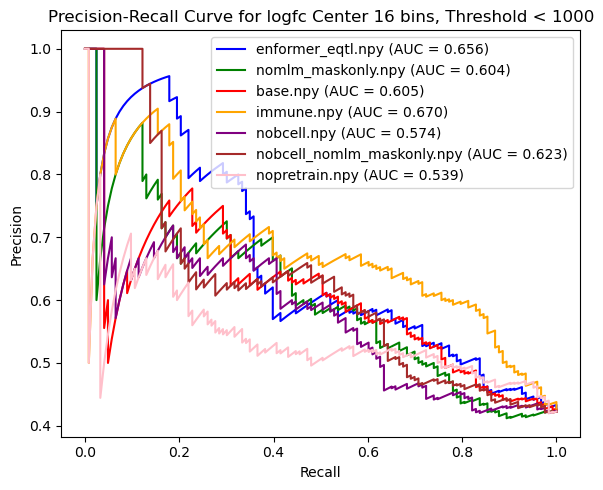

Plotting for threshold: 10000


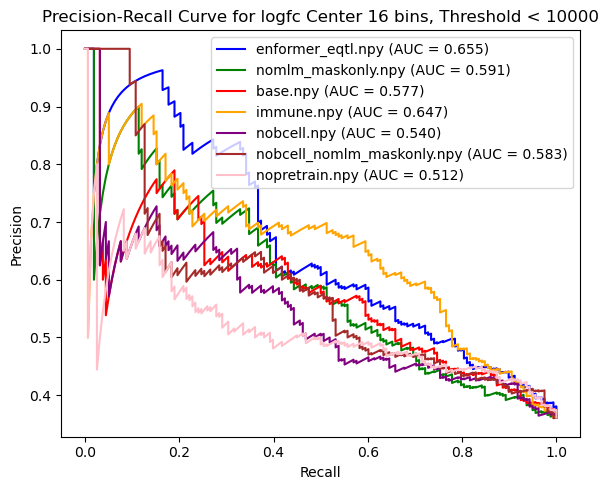

Plotting for threshold: 100000


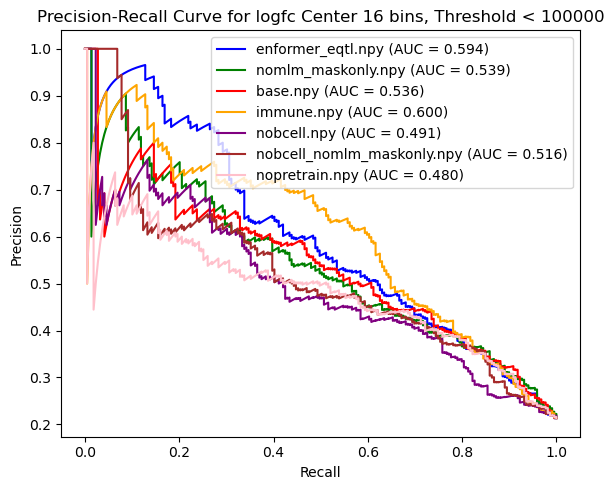

Plotting for threshold: 196608


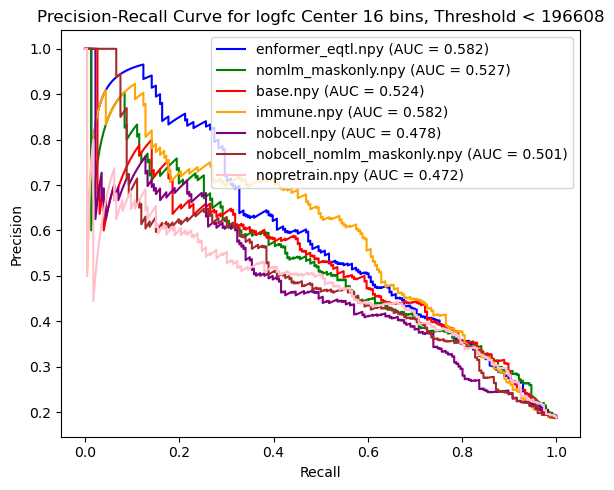

Plotting for threshold: 524288


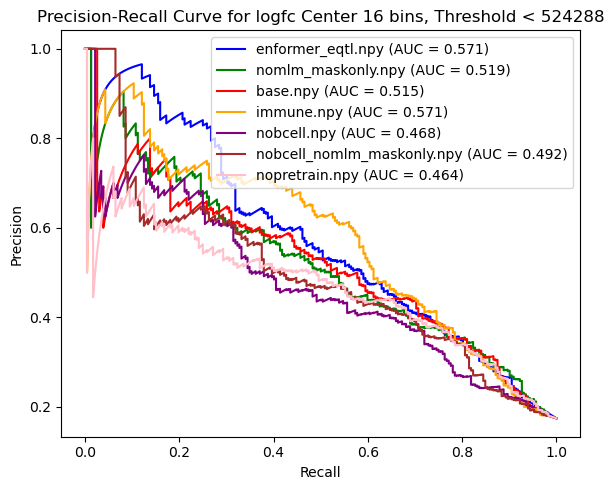

In [9]:
#now the thresholds
thresholds = [1000, 10000, 100000, 196608, 524288]

files = ['enformer_eqtl.npy', 'nomlm_maskonly.npy', 'base.npy', 'immune.npy', 'nobcell.npy', 'nobcell_nomlm_maskonly.npy', 'nopretrain.npy']
for threshold in thresholds:
    print(f'Plotting for threshold: {threshold}')
    mask = distances < threshold
    plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, center=True, title=f'Center 16 bins, Threshold < {threshold}', mask=mask)
# plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, center=True, title='Center 16 bins')

Processing threshold: 1000
Processing threshold: 10000
Processing threshold: 100000
Processing threshold: 196608
Processing threshold: 524288


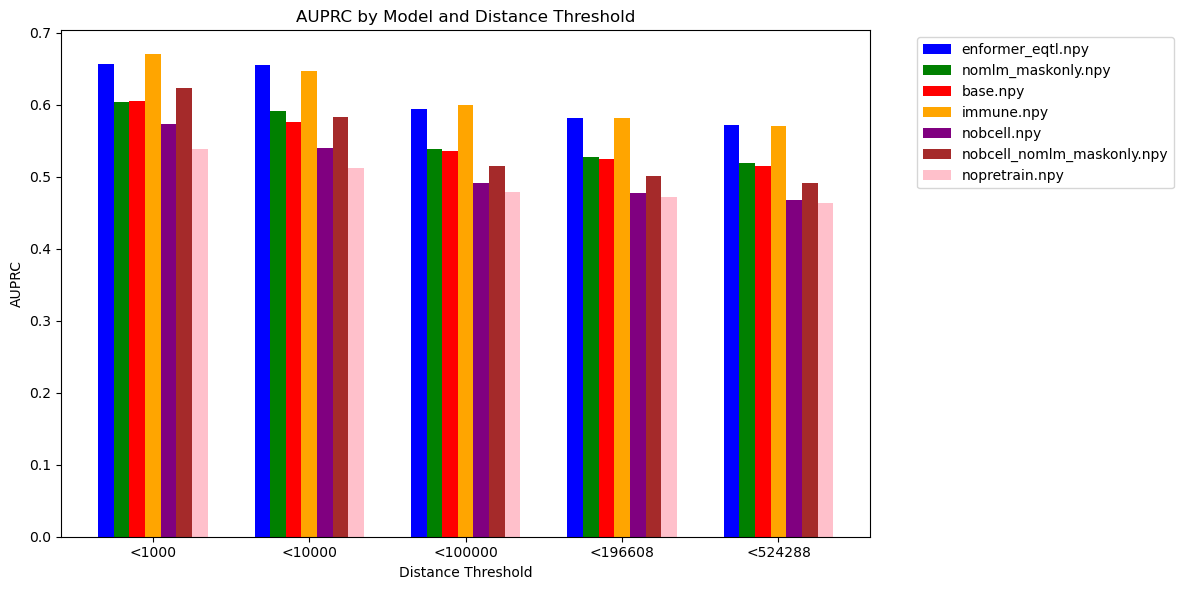

In [10]:
#let's do a bar plot

auprc_by_threshold = []

for threshold in thresholds:
    print(f'Processing threshold: {threshold}')
    mask = distances < threshold
    auprc_for_files = []

    for i, file in enumerate(files):
        eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{file}')
        center_start = eqtl_data.shape[1] // 2 - 16 // 2
        center_end = center_start + 16
        eqtl_data = eqtl_data[:, center_start:center_end, :]

        out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])
        non_zero_mask = mask  # apply threshold mask

        metric_idx = 0  # logfc
        selected_metric = np.abs(out[metric_idx])[non_zero_mask]
        pr, rc, _ = precision_recall_curve(labels[non_zero_mask], selected_metric)
        pr_auc = auc(rc, pr)
        auprc_for_files.append(pr_auc)

    auprc_by_threshold.append(auprc_for_files)
    
auprc_by_threshold = np.array(auprc_by_threshold)  # shape: (len(thresholds), len(files))

x = np.arange(len(thresholds))  # group positions
bar_width = 0.1
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink']

plt.figure(figsize=(12, 6))
for i in range(len(files)):
    plt.bar(x + i * bar_width, auprc_by_threshold[:, i], width=bar_width, color=colors[i % len(colors)], label=files[i])

plt.xticks(x + (len(files)-1)/2 * bar_width, [f'<{t}' for t in thresholds])
plt.xlabel('Distance Threshold')
plt.ylabel('AUPRC')
plt.title('AUPRC by Model and Distance Threshold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Processing threshold: 500
Processing threshold: 1000
Processing threshold: 10000
Processing threshold: 98304
Processing threshold: 262144


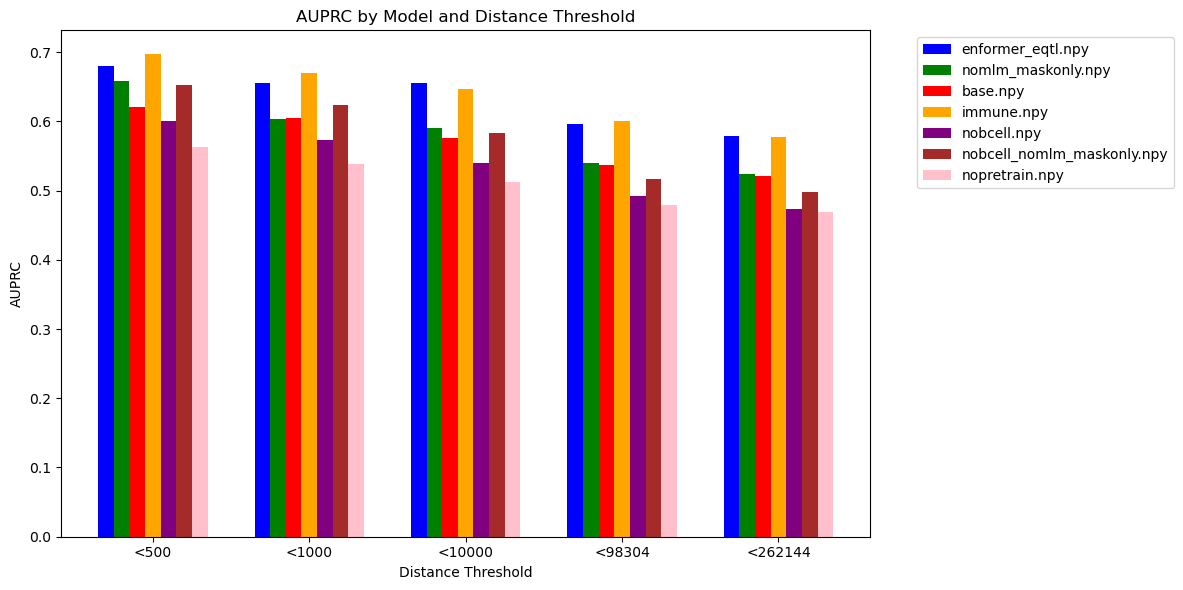

In [11]:
#let's do the thresholds that make more sense
thresholds = [500, 1000, 10000, 196608//2, 524288//2]
auprc_by_threshold = []

for threshold in thresholds:
    print(f'Processing threshold: {threshold}')
    mask = distances < threshold
    auprc_for_files = []

    for i, file in enumerate(files):
        eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{file}')
        center_start = eqtl_data.shape[1] // 2 - 16 // 2
        center_end = center_start + 16
        eqtl_data = eqtl_data[:, center_start:center_end, :]

        out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])
        non_zero_mask = mask  # apply threshold mask

        metric_idx = 0  # logfc
        selected_metric = np.abs(out[metric_idx])[non_zero_mask]
        pr, rc, _ = precision_recall_curve(labels[non_zero_mask], selected_metric)
        pr_auc = auc(rc, pr)
        auprc_for_files.append(pr_auc)

    auprc_by_threshold.append(auprc_for_files)
    
auprc_by_threshold = np.array(auprc_by_threshold)  # shape: (len(thresholds), len(files))

x = np.arange(len(thresholds))  # group positions
bar_width = 0.1
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink']

plt.figure(figsize=(12, 6))
for i in range(len(files)):
    plt.bar(x + i * bar_width, auprc_by_threshold[:, i], width=bar_width, color=colors[i % len(colors)], label=files[i])

plt.xticks(x + (len(files)-1)/2 * bar_width, [f'<{t}' for t in thresholds])
plt.xlabel('Distance Threshold')
plt.ylabel('AUPRC')
plt.title('AUPRC by Model and Distance Threshold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Plotting for threshold: 500


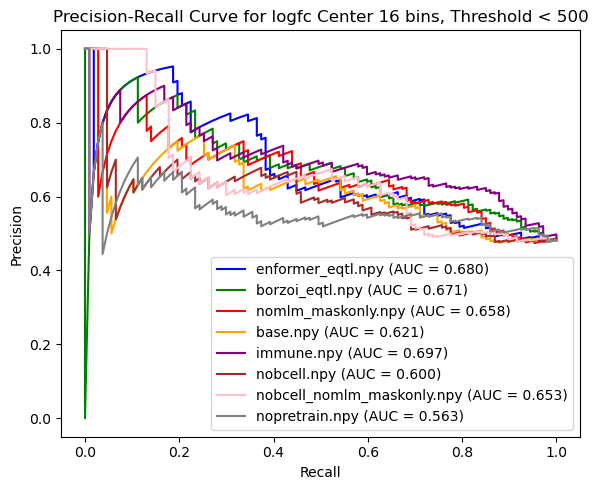

Plotting for threshold: 1000


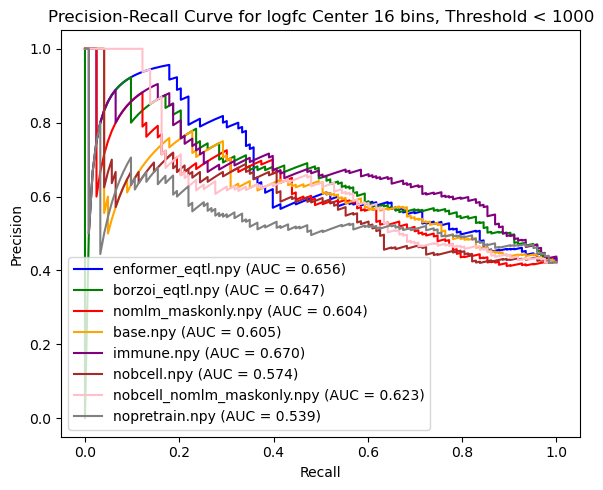

Plotting for threshold: 10000


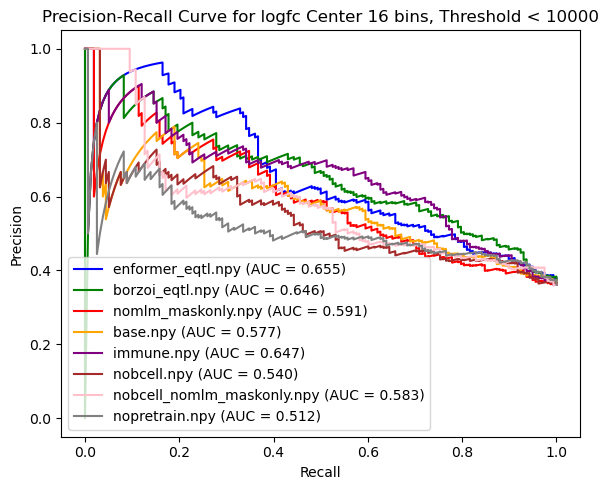

Plotting for threshold: 98304


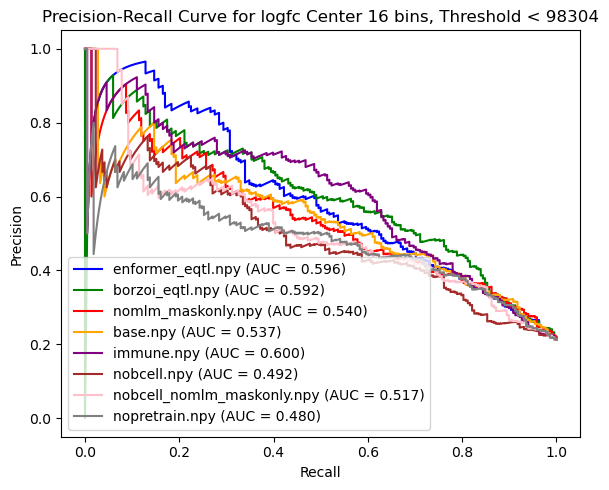

Plotting for threshold: 262144


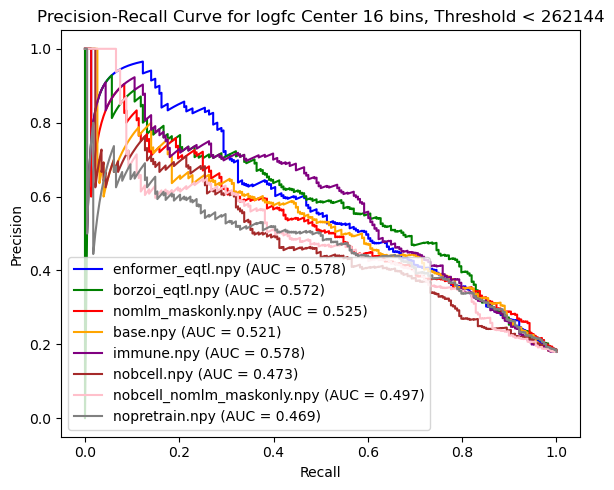

In [12]:
#let's also do borzoi

files = ['enformer_eqtl.npy', 'borzoi_eqtl.npy', 'nomlm_maskonly.npy', 'base.npy', 'immune.npy', 'nobcell.npy', 'nobcell_nomlm_maskonly.npy', 'nopretrain.npy']
for threshold in thresholds:
    print(f'Plotting for threshold: {threshold}')
    mask = distances < threshold
    plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, center=True, title=f'Center 16 bins, Threshold < {threshold}', mask=mask)

In [14]:
def plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, center=False, title='', mask=None):
    metric_index_map = {
        'logfc': 0,
        'log_probs_diff_abs_sum': 1,
        'JSD': 2,
        'IED1': 3,
        'IED2': 4
    }
    assert metric_name in metric_index_map, f"Invalid metric: {metric_name}"
    metric_idx = metric_index_map[metric_name]

    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    plt.figure(figsize=(6, 5))
    legend_entries = []

    for i, file in enumerate(files):
        eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{file}')
        if center:
            center_start = eqtl_data.shape[1] // 2 - center[i] // 2
            center_end = center_start + center[i]
            eqtl_data = eqtl_data[:, center_start:center_end, :]
        out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])

        if mask is None: #can supply a mask or can use default mask of the first value!
            if i == 0:
                non_zero_mask = (out[0] != 0)
        else:
            non_zero_mask = mask

        selected_metric = np.abs(out[metric_idx])[non_zero_mask]
        precision, recall, _ = precision_recall_curve(labels[non_zero_mask], selected_metric)
        pr_auc = auc(recall, precision)

        line, = plt.plot(recall, precision, label=file, color=colors[i % len(colors)])
        legend_entries.append((pr_auc, line, f'{file} (AUC = {pr_auc:.3f})'))

    plt.title(f'Precision-Recall Curve for {metric_name} {title}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')

    if sort_legend_by_auc:
        legend_entries.sort(reverse=True, key=lambda x: x[0])  # sort by AUC descending
    handles = [entry[1] for entry in legend_entries]
    labels_sorted = [entry[2] for entry in legend_entries]

    plt.legend(handles, labels_sorted)
    plt.tight_layout()
    plt.show()

Plotting for threshold: 500


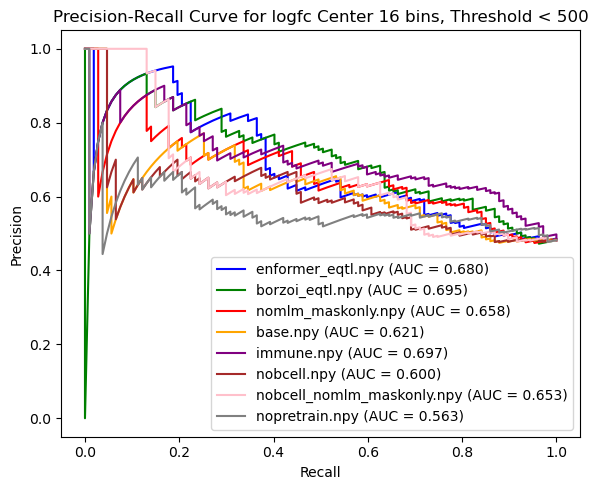

Plotting for threshold: 1000


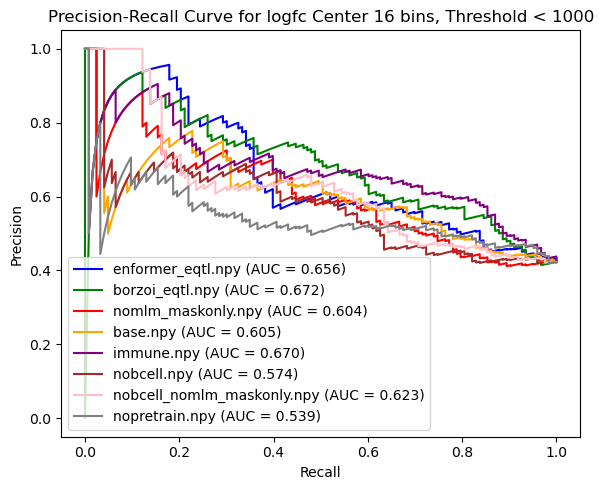

Plotting for threshold: 10000


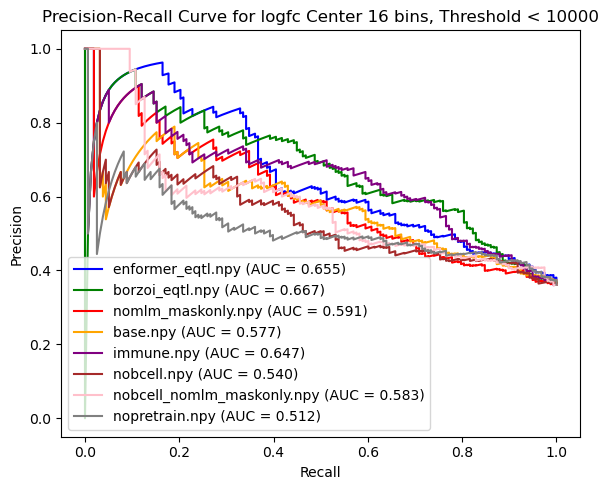

Plotting for threshold: 98304


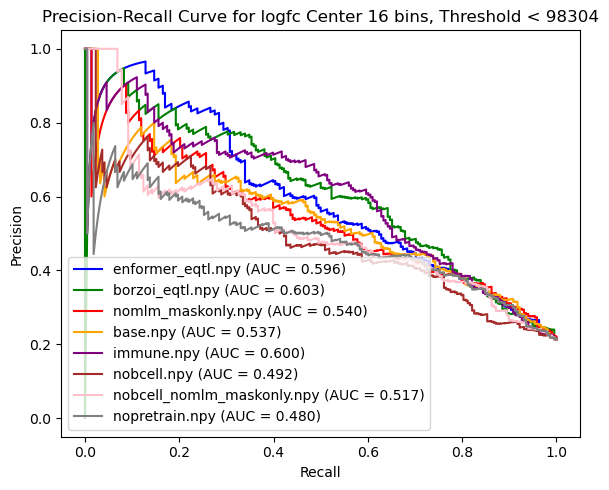

Plotting for threshold: 262144


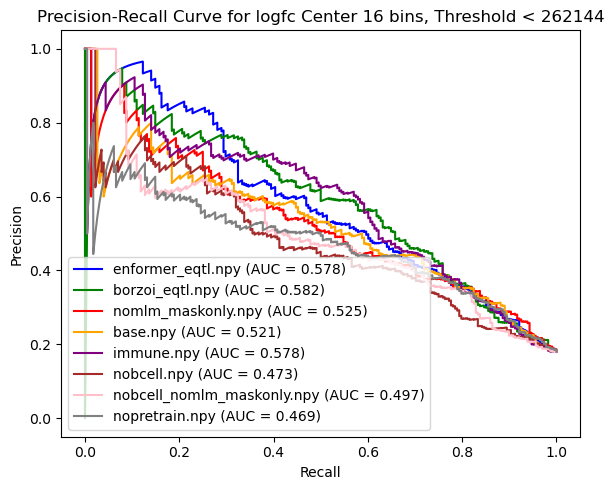

In [16]:
files = ['enformer_eqtl.npy', 'borzoi_eqtl.npy', 'nomlm_maskonly.npy', 'base.npy', 'immune.npy', 'nobcell.npy', 'nobcell_nomlm_maskonly.npy', 'nopretrain.npy']
center = [16, 16*4, 16, 16, 16, 16, 16, 16]
for threshold in thresholds:
    print(f'Plotting for threshold: {threshold}')
    mask = distances < threshold
    plot_selected_metric(files, labels, metric_name='logfc', sort_legend_by_auc=False, center=center, title=f'Center 16 bins, Threshold < {threshold}', mask=mask)

Processing threshold: 500
Processing threshold: 1000
Processing threshold: 10000
Processing threshold: 98304
Processing threshold: 262144


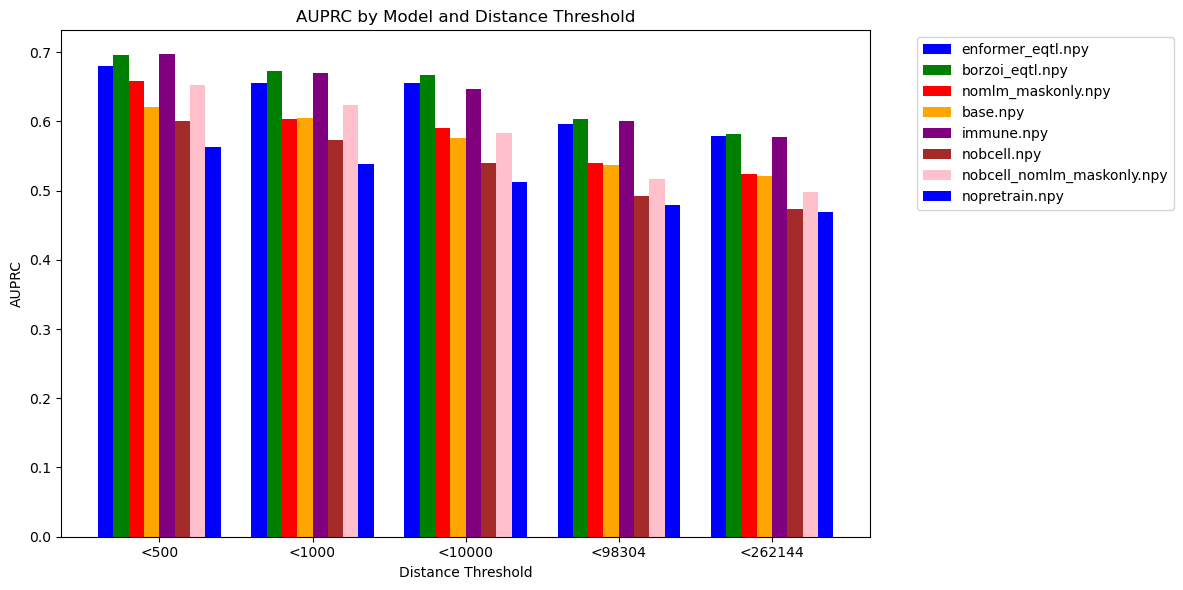

In [17]:
thresholds = [500, 1000, 10000, 196608//2, 524288//2]
auprc_by_threshold = []

for threshold in thresholds:
    print(f'Processing threshold: {threshold}')
    mask = distances < threshold
    auprc_for_files = []

    for i, file in enumerate(files):
        eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{file}')
        center_start = eqtl_data.shape[1] // 2 - center[i] // 2
        center_end = center_start + center[i]
        eqtl_data = eqtl_data[:, center_start:center_end, :]

        out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])
        non_zero_mask = mask  # apply threshold mask

        metric_idx = 0  # logfc
        selected_metric = np.abs(out[metric_idx])[non_zero_mask]
        pr, rc, _ = precision_recall_curve(labels[non_zero_mask], selected_metric)
        pr_auc = auc(rc, pr)
        auprc_for_files.append(pr_auc)

    auprc_by_threshold.append(auprc_for_files)
    
auprc_by_threshold = np.array(auprc_by_threshold)  # shape: (len(thresholds), len(files))

x = np.arange(len(thresholds))  # group positions
bar_width = 0.1
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink']

plt.figure(figsize=(12, 6))
for i in range(len(files)):
    plt.bar(x + i * bar_width, auprc_by_threshold[:, i], width=bar_width, color=colors[i % len(colors)], label=files[i])

plt.xticks(x + (len(files)-1)/2 * bar_width, [f'<{t}' for t in thresholds])
plt.xlabel('Distance Threshold')
plt.ylabel('AUPRC')
plt.title('AUPRC by Model and Distance Threshold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Processing threshold: 1000


Processing threshold: 262144


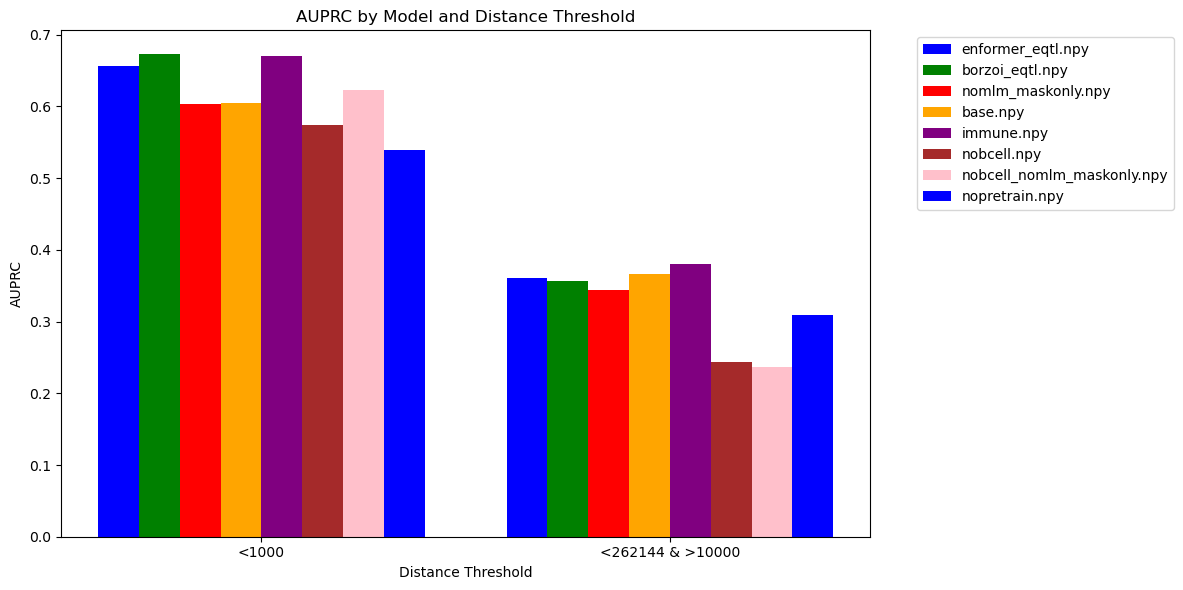

In [22]:
#let's also only look at variants further than 10k but less than 524288//2
thresholds = [1000, 524288//2]
auprc_by_threshold = []

for threshold in thresholds:
    print(f'Processing threshold: {threshold}')
    mask = distances < threshold
    if threshold == 524288//2:
        mask = (distances < threshold) & (distances > 10000)
    auprc_for_files = []

    for i, file in enumerate(files):
        eqtl_data = np.load(f'/data1/lesliec/sarthak/data/joint_playground/eQTL/EPCOTv2_LCLs/{file}')
        center_start = eqtl_data.shape[1] // 2 - center[i] // 2
        center_end = center_start + center[i]
        eqtl_data = eqtl_data[:, center_start:center_end, :]

        out = predict_snp_effect_scores(eqtl_data[:, :, 0], eqtl_data[:, :, 1])
        non_zero_mask = mask  # apply threshold mask

        metric_idx = 0  # logfc
        selected_metric = np.abs(out[metric_idx])[non_zero_mask]
        pr, rc, _ = precision_recall_curve(labels[non_zero_mask], selected_metric)
        pr_auc = auc(rc, pr)
        auprc_for_files.append(pr_auc)

    auprc_by_threshold.append(auprc_for_files)
    
auprc_by_threshold = np.array(auprc_by_threshold)  # shape: (len(thresholds), len(files))

x = np.arange(len(thresholds))  # group positions
bar_width = 0.1
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink']

plt.figure(figsize=(12, 6))
for i in range(len(files)):
    plt.bar(x + i * bar_width, auprc_by_threshold[:, i], width=bar_width, color=colors[i % len(colors)], label=files[i])

plt.xticks(x + (len(files)-1)/2 * bar_width, [f'<{1000}', f'<{524288//2} & >10000'])
plt.xlabel('Distance Threshold')
plt.ylabel('AUPRC')
plt.title('AUPRC by Model and Distance Threshold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()